
 # <center> Music-Learning</center>

<center>
Caliandro Pierciro (0299815)
    <br>
Falcone Gian Marco (0300251)
</center>

# Introduction and scope of the notebook
This notebook aims to show the application of Machine Learning models to solve the problem of music genre recognition.

This problem is well know and studied by the literature, since it has a wide set of applications.

For the data we used the [FMA dataset](https://github.com/mdeff/fma), which contains differents zips of .mp3 audio files.
Given the size of the zip, we decided to use the __medium__ version to extract the feature and the classification is performed on the top 16 root genres that are explained in more details in [`1`](https://arxiv.org/abs/1612.01840).

In [1]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.svm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel, RFE, RFECV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LassoCV
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Classifiers
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

import librosa
from IPython.display import Audio
import scipy
from tinytag import TinyTag
from Dataset_Generator import calculate_metrics, get_features, retrieve_header, post_processing
import pandas as pd

import ast
import os
import cmath
import csv
import math

from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler

# utility imports from .py files
from plot_utils import basic_plot, bar_plot, three_group_bar_plot
from dataset_utils import drop_complex_cols, get_top_genres, load, write_metrics_header, write_metrics, write_tuning_header, write_on_tuning_file 
from utils import write_cm_on_file, compute_class_metrics

We present two versions of the notebook, associated with the two binary value of  __VERSION__:
- 0: use the dataset from FMA repository
- 1: use our dataset, extracted by the mp3 archive of the FMA repository
<br><br>

There is also an __EXEC_PROFILE__ variable that is a dictonary which value will be used as an "operational profile".

In [2]:
VERSION = 1
EXEC_PROFILE = {"PCA": False, "FS": False, "SMOTE": False, "OVERS": False}

header_str = "PCA,FS,SMOTE,OVERS,accuracy\n"
baseline_str = str(EXEC_PROFILE["PCA"]) + ","+str(EXEC_PROFILE["FS"])+","+str(EXEC_PROFILE["SMOTE"])+","+str(EXEC_PROFILE["OVERS"])

# Dataset generation


In [ ]:
file_name = 'raw_csv_file.csv'

# open the file in the write mode
f = open(file_name, 'w', newline='')

# create the csv writer
writer = csv.writer(f)

# write header to the csv file
header = retrieve_header()
writer.writerow(header)

# write data to the csv file
get_features(writer)

# close the file
f.close()

post_processing(file_name)

C:\ProgramData\Anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


## Data preprocessing
There is the need to do some preliminar operations on the data extracted by the .mp3 files:

1. First, there are some columns (the 'Fourier' related) that have complex numbers as values.
These values can't be treated by the ML models so are discared

2. The labels have to be encoded to be processed in the right way

In [3]:
# Open file, extract feature set and label set
if VERSION:
    path = "out.csv"
    dataframe = pd.read_csv(path)
    y = dataframe["genre"]
    dataframe = dataframe.drop(columns=["title", "artist", "filename", "album", "genre"])
    dataframe = dataframe.drop(columns=drop_complex_cols(dataframe))
    X = dataframe.drop(columns=["fourier_tempogram_std"])

    # Label encoding and extraction of uniques for later purposes
    le = LabelEncoder()
    y = le.fit_transform(y)
    labels = pd.Series(y).unique()
    
else:
    path = "dataset/fma_metadata/"
    tracks_file = "tracks.csv"
    features_file = "features.csv"
    ds_features = load(path+features_file)
    ds_tracks = load(path+tracks_file)
    medium = ds_tracks['set', 'subset'] <= 'medium'
    X = ds_features.loc[medium, 'mfcc'] # mel-frequency cepstral coeffcients: TODO add details 
    y = ds_tracks.loc[medium, ('track', 'genre_top')]
    labels = y.unique()

In [5]:
# Tuned parameters for the "plain" case
if EXEC_PROFILE["SMOTE"]:
    #SVM
    C_best = 50
    #LR
    solver = 'newton-cg'
    penalty = 'none'
    #kNN
    n_neighbours = 2
    #MLP
    hidden_layer_sizes = 150
    alpha = 1e-4
    #DT
elif EXEC_PROFILE["OVERS"]:
    # SVM
    C_best = 100
    # LR
    solver = 'newton-cg'
    # kNN
    n_neighbours = 2
    # MLP
    hidden_layer_sizes = 100
    alpha = 1e-5
    # DT
else:
    # SVM
    C_best = 50
    # LR
    solver = 'newton-cg'
    penalty='l2'
    # kNN
    n_neighbours = 20
    # MLP
    hidden_layer_sizes = 75
    alpha = 1e-5
    # DT
    min_samples_leaf = 75

## Feature manipulation

### Feature selection and PCA
Feature selection was the first thing applied, using a linear model as basis
<br><br>

Principal Component Analysis for feature extraction

In [4]:
# check if feature selection is enabled for the current run
if EXEC_PROFILE["FS"]:
    print(X.shape)
    X_new = RFECV(LassoCV(tol=1e-1), step=1, cv=5).fit(X, y).transform(X)
    print(X_new.shape)
    
    # Split into train, validate, test
    X_train, X_test, y_train, y_test = train_test_split(X_new, y, random_state=42, 
                                                                    test_size=0.10)
    X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, 
                                                                random_state=42, test_size=0.10)

# check if PCA is enabled for the current run
elif EXEC_PROFILE["PCA"]:
    n_components = [1, 2, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    variances = []

    for components in n_components:
        pca = PCA(n_components=components)
        pca.fit(X, y)
        variances.append(np.asarray(pca.explained_variance_ratio_).sum())

    basic_plot(fig_size=(16,9), x_array=n_components, y_array=variances, 
               x_label="Variance ratio", y_label="number of principal components", 
               title="Variance ratio for PCA")
    
    # TODO: formattare questa tabella
    print(pd.DataFrame(n_components, variances))

    
    pca = PCA(n_components=40)
    X_pca = pca.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, random_state=42, test_size=0.10)
    X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, 
                                                                random_state=42, test_size=0.10)
    
else:
    # Split into train/validate/test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.10)
    X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, 
                                                                random_state=42, test_size=0.10)

as shown by the data, the first value for PCA that ensures variance = 1 is 40 components, so that value has been chosen.

### Dataset resampling
We propose both SMOTE and RandomOversampler methods

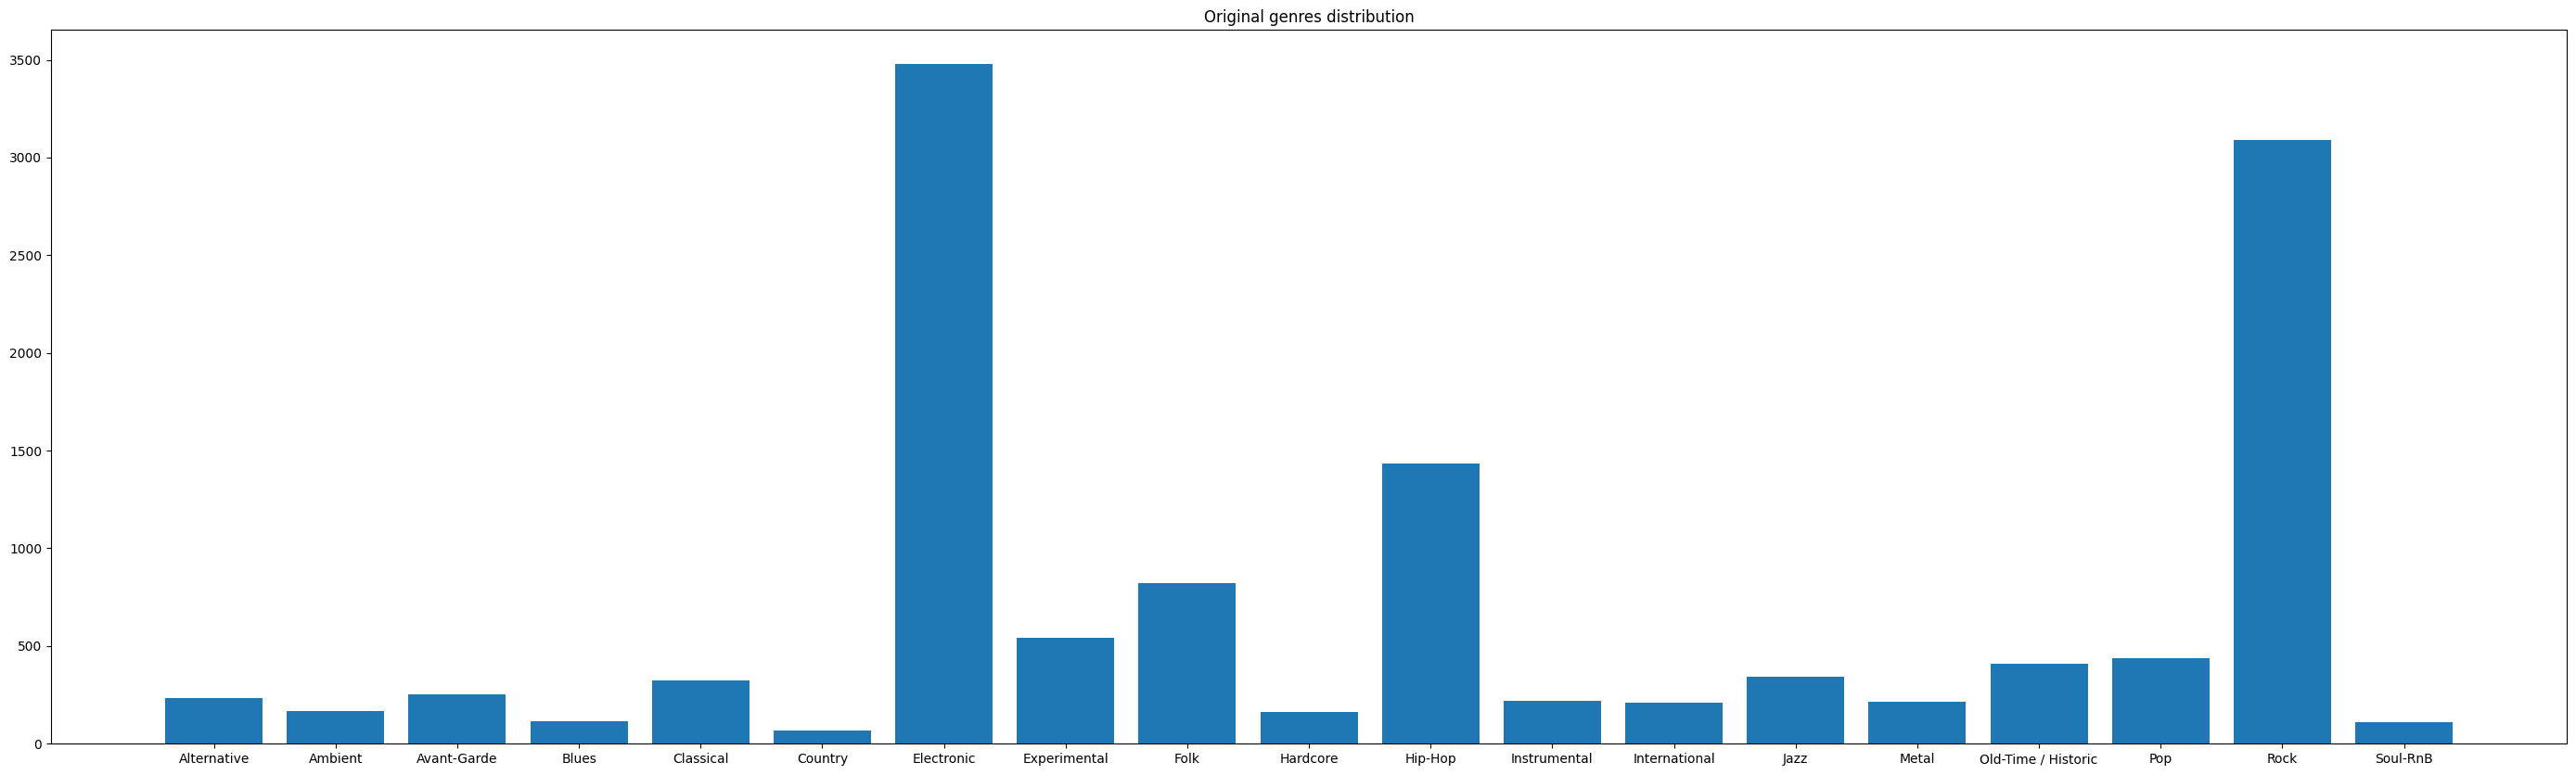

In [5]:
orig_labels = le.inverse_transform(labels)
orig_labels.sort()

# summarize distribution 
counter = Counter(y_train) 
strategy = {} 
for k,v in counter.items(): 
    strategy[k] = v
    
sorted_dict = dict(sorted(strategy.items()))
bar_plot((35,10), sorted_dict.values(), orig_labels, 'Original genres distribution')
     
if EXEC_PROFILE["OVERS"] or EXEC_PROFILE["SMOTE"]:
    # define oversampling strategy 
    max_class = max(strategy, key=strategy.get) 

    for k,v in strategy.items(): 
        if v < strategy[max_class]/24: 
            strategy[k] = v * 12 
        elif v < strategy[max_class]/20: 
            strategy[k] = v * 10
        elif v < strategy[max_class]/16: 
            strategy[k] = v * 8
        elif v < strategy[max_class]/12: 
            strategy[k] = v * 6
        elif v < strategy[max_class]/8: 
            strategy[k] = v * 4
        elif v < strategy[max_class]/6: 
            strategy[k] = math.ceil(v * 3) 
        elif v < strategy[max_class]/4: 
            strategy[k] = math.ceil(v * 2) 
        elif v < strategy[max_class]/2: 
            strategy[k] = math.ceil(v * 1.5) 
        
    # transform the dataset 
    if EXEC_PROFILE["SMOTE"]:
        oversample = SMOTE(sampling_strategy=strategy) 
        # fit and apply the transform 
        X_train_smote, y_train_smote = oversample.fit_resample(X_train, y_train)
        
    elif EXEC_PROFILE["OVERS"]:
        oversample = RandomOverSampler(sampling_strategy=strategy) 
        # fit and apply the transform 
        X_train_os, y_train_os = oversample.fit_resample(X_train, y_train)
    
    sorted_dict = dict(sorted(strategy.items()))
    bar_plot((35,10), sorted_dict.values(), orig_labels, 'Genres distribution with OverSampling')

# Model tuning
We did model tuning to find the suited parameters for each classifier.
<br><br>
We tested each run profile

In [6]:
n_components_pca = [15, 30, 40, 60, 90]

## SVM tuning
The first classifier evaluated was SVM.
<br>
Based on the online literature, the suited kernel function seems to be 'rfb', so it was our choice to use it too.
We recall that the radial basis function (rbf) $K(\textbf{x}, \textbf{x'})$ has the following form:<br>
<center>$K(\textbf{x}, \textbf{x'}) = e^{-\frac{||\textbf{x} - \textbf{x'}||^2}{2\sigma^2}}$</center>
<br>
The SVC implementation offered by scikit uses, among the parameters, a $C$ that is used for regularization, with a squared l2 penality function.
<br><br>
So, for tuning, different values of C have been considered

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

# Construct a pipeline
scaler = StandardScaler()
pca = PCA()
pca.fit(X_validate, y_validate)
svc = SVC()#.fit(X_validate, y_validate)
#rfecv = RFECV(RandomForestClassifier(n_estimators=30, random_state=42, class_weight="balanced"), 
 #             step=1, cv=5, scoring = 'roc_auc').fit(X, y)

pipe = Pipeline(steps=[("scaler", scaler), ("pca", pca), ("svc", svc)])

kernels = ['rbf']
C_values = [1, 10, 25, 50, 100]
#n_components = [1, 2, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
#n_components = [10, 20, 30, 40]
#param_grid = {'C': C_values,'kernel': kernels}
param_grid = { "pca__n_components": n_components_pca, 
              "svc__C": C_values,
              "svc__kernel": kernels
             }

grid_search = GridSearchCV(pipe, param_grid, n_jobs=2)
grid_search.fit(X_validate, y_validate)
print("Best parameter (CV score=%0.3f):" % grid_search.best_score_)
print(grid_search.best_params_)
#grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2,cv=3)
#grid.fit(X_train,y_train)
#print(grid.best_estimator_)

Best parameter (CV score=0.571):
{'pca__n_components': 90, 'svc__C': 1, 'svc__kernel': 'rbf'}


## LR tuning
The second classifier used is Logistic Regression.
<br>
This classifier can use different solvers with different associated penalities
<br>
__TODO__: aggiungi 

In [8]:
'''
model_solvers = ['newton-cg', 'sag', 'saga', 'lbfgs']
penalties = ['l1', 'l2', 'None']
param_grid = {'solver': model_solvers, 'penalty': penalties}

grid = GridSearchCV(LogisticRegression(),param_grid,refit=True,verbose=2,cv=3)
grid.fit(X_train,y_train)
print(grid.best_estimator_)
'''
scaler = StandardScaler()
pca = PCA()
pca.fit(X_validate, y_validate)
logistic = LogisticRegression()

pipe = Pipeline(steps=[("scaler", scaler), ("pca", pca), ("logistic", logistic)])

model_solvers = ['newton-cg', 'sag', 'saga', 'lbfgs']
penalties = ['l1', 'l2', 'None']
#n_components = [1, 2, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
#n_components = [10, 20, 30, 40]
#param_grid = {'C': C_values,'kernel': kernels}
param_grid = { "pca__n_components": n_components_pca, 
              "logistic__solver": model_solvers,
              "logistic__penalty": penalties
             }

grid_search = GridSearchCV(pipe, param_grid, n_jobs=2)
grid_search.fit(X_validate, y_validate)
print("Best parameter (CV score=%0.3f):" % grid_search.best_score_)
print(grid_search.best_params_)

/usr/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  w

/usr/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  w

/usr/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also

/usr/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
175 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/lib/python

Best parameter (CV score=0.563):
{'logistic__penalty': 'l2', 'logistic__solver': 'saga', 'pca__n_components': 90}


/usr/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


## kNN tuning
As third classifier we have k-Nearest-Neighbours.
<br>
This classifier works by considering the $k$ nearest points to a given $\textbf{x}$
<br>
__TODO__: aggiungi

In [9]:
'''
n_neighbors = [1, 2, 3, 5, 10, 15, 20, 25, 50, 100]

param_grid = {'n_neighbors': n_neighbors}

grid = GridSearchCV(KNeighborsClassifier(),param_grid,refit=True,verbose=2,cv=3)
grid.fit(X_train,y_train)
print(grid.best_estimator_)
'''

scaler = StandardScaler()
pca = PCA()
pca.fit(X_validate, y_validate)
knn = KNeighborsClassifier()

pipe = Pipeline(steps=[("scaler", scaler), ("pca", pca), ("knn", knn)])


#n_components = [1, 2, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
n_neighbors = [1, 2, 3, 5, 10, 15, 20, 25, 50, 100]
param_grid = { "pca__n_components": n_components_pca,
              "knn__n_neighbors": n_neighbors
             }

grid_search = GridSearchCV(pipe, param_grid, n_jobs=2)
grid_search.fit(X_validate, y_validate)
print("Best parameter (CV score=%0.3f):" % grid_search.best_score_)
print(grid_search.best_params_)

Best parameter (CV score=0.509):
{'knn__n_neighbors': 15, 'pca__n_components': 30}


## MLP tuning
The fourth considered was Multi Layer Perceptron.
This class has different parameters that can be tuned:
1. hidden_layer_sizes, where the The ith element represents the number of neurons in the ith hidden layer
1. alpha: Strength of the L2 regularization term
<br>

__TODO__: aggiungi

In [10]:
'''
hlayers = [10, 20, 50, 75, 100, 150]
alphas = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
param_grid = {'alpha': alphas, 'hidden_layer_sizes': hlayers}

grid = GridSearchCV(MLPClassifier(),param_grid,refit=True,verbose=2,cv=3)
grid.fit(X_train,y_train)
print(grid.best_estimator_)
'''

scaler = StandardScaler()
pca = PCA()
pca.fit(X_validate, y_validate)
mlp = MLPClassifier()

pipe = Pipeline(steps=[("scaler", scaler), ("pca", pca), ("mlp", mlp)])


#n_components = [1, 2, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
hlayers = [10, 20, 50, 75, 100, 150]
alphas = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
param_grid = { "pca__n_components": n_components_pca,
              "mlp__alpha": alphas,
              "mlp__hidden_layer_sizes": hlayers
             }

grid_search = GridSearchCV(pipe, param_grid, n_jobs=2)
grid_search.fit(X_validate, y_validate)
print("Best parameter (CV score=%0.3f):" % grid_search.best_score_)
print(grid_search.best_params_)

/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: 

/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: 

/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: 

/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: 

/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: 

/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: 

/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: 

/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: 

/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: 

/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: 

/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: 

/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: 

/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: 

/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: 

/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: 

/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: 

/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: 

/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: 

/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: 

/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: 

/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: 

Best parameter (CV score=0.561):
{'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': 20, 'pca__n_components': 90}


/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


## DT tuning
As fifth and last classifier, we used decision three. 
<br>

__TODO__: aggiungi

In [11]:
'''
min_samples_leaf = [1, 5, 10, 25, 50, 75, 100]
min_samples_split = [2, 4, 8]
param_grid = {'min_samples_leaf': min_samples_leaf, 'min_samples_split': min_samples_split}

grid = GridSearchCV(DecisionTreeClassifier(),param_grid,refit=True,verbose=2,cv=3)
grid.fit(X_train,y_train)
print(grid.best_estimator_)
'''

scaler = StandardScaler()
pca = PCA()
pca.fit(X_validate, y_validate)
dt = DecisionTreeClassifier()

pipe = Pipeline(steps=[("scaler", scaler), ("pca", pca), ("dt", dt)])


#n_components = [1, 2, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
min_samples_leaf = [1, 5, 10, 25, 50, 75, 100]
min_samples_split = [2, 4, 8]
param_grid = { "pca__n_components": n_components_pca, 
              "dt__min_samples_leaf": min_samples_leaf,
              "dt__min_samples_split": min_samples_split
             }

grid_search = GridSearchCV(pipe, param_grid, n_jobs=2)
grid_search.fit(X_validate, y_validate)
print("Best parameter (CV score=%0.3f):" % grid_search.best_score_)
print(grid_search.best_params_)

Best parameter (CV score=0.451):
{'dt__min_samples_leaf': 25, 'dt__min_samples_split': 4, 'pca__n_components': 30}


# Classifiers metrics and comparison
Last, we evaluate performance metrics for the different classifiers and compare the
results obtained.

4 different metrics for each classifier are computed and evaluated:
<br>
----------------------------------------------------------------------------
- Metric: &emsp;&emsp;&emsp;&emsp;&emsp; Expression
----------------------------------------------------------------------------
- Accuracy: &emsp;&emsp;&emsp; $\tfrac{TN + TP}{TP+FP+TN+FN}$
- Precision: &emsp;&emsp;&emsp;&emsp;&emsp; $\tfrac{TP}{TP + FP}$
- Recall: &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; $\tfrac{TP}{TP + FN}$
- F1-score: &emsp;&emsp;&emsp;     $2 \cdot \tfrac{Precision \cdot Recall}{Precision + Recall}$
----------------------------------------------------------------------------

were:
- TN is the number of True Negative instances
- TP is the number of True Positive instances
- FP is the number of False Positive instances
- FN is the number of False Negative instances

<br><br>
N.B: given the fact that the dataset is not well balanced (i.e: there is not the same amount of samples for each class) the accuracy metrics gets impacted so it is not the best metric to takes into account.
That's the reason why we decided to show other metrics that are less affected by dataset balance.

## SVM classification

### SVM without tweaks

In [8]:
svm_clf = skl.svm.SVC(C=C_best, kernel='rbf').fit(X_train, y_train)
svm_val_predict = cross_val_predict(svm_clf, X_validate, y_validate, cv=5)

# vector structure: [report, precision, recall, f1-score]
svm_results = compute_class_metrics(predictions= le.inverse_transform(svm_val_predict), 
                                y_set= le.inverse_transform(y_validate), 
                                labels= le.inverse_transform(labels))

svm_report = svm_results[0]
svm_precision = svm_results[1]
svm_recall = svm_results[2]
svm_f1 = svm_results[3]
#svm_cm = confusion_matrix(y_test, svm_predictions, labels=labels)

    #print("------------------------------ SVM completed ------------------------------")

[{'Hip-Hop': {'precision': 0.544, 'recall': 0.43037974683544306, 'f1-score': 0.480565371024735, 'support': 158}, 'Pop': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 51}, 'Folk': {'precision': 0.35294117647058826, 'recall': 0.37894736842105264, 'f1-score': 0.36548223350253806, 'support': 95}, 'Jazz': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 35}, 'Metal': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 21}, 'Electronic': {'precision': 0.5196998123827392, 'recall': 0.6977329974811083, 'f1-score': 0.5956989247311828, 'support': 397}, 'Avant-Garde': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 29}, 'Rock': {'precision': 0.516728624535316, 'recall': 0.7679558011049724, 'f1-score': 0.6177777777777779, 'support': 362}, 'Soul-RnB': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 13}, 'International': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 21}, 'Blues': {'precision': 0.0, 'recall': 0.0, 'f1-

/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: Undefin

### SVM with oversampling

In [105]:
svm_clf_os = skl.svm.SVC(C=C_best, kernel='rbf').fit(X_train_os, y_train_os)
svm_val_predict_os = cross_val_predict(svm_clf_os, X_validate, y_validate, cv=5)

# vector structure: [report, precision, recall, f1-score]
svm_results_os = compute_class_metrics(predictions= le.inverse_transform(svm_val_predict_os), 
                                y_set= le.inverse_transform(y_validate), 
                                labels= le.inverse_transform(labels))

svm_report_os = svm_results_os[0]
svm_precision_os = svm_results_os[1]
svm_recall_os = svm_results_os[2]
svm_f1_os = svm_results_os[3]

### SVM with SMOTE

In [43]:
svm_clf_smote = skl.svm.SVC(C=C_best, kernel='rbf').fit(X_train_smote, y_train_smote)
svm_val_predict_smote = cross_val_predict(svm_clf_smote, X_validate, y_validate, cv=5)

# vector structure: [report, precision, recall, f1-score]
svm_results_smote = compute_class_metrics(
    predictions= le.inverse_transform(svm_val_predict_smote), 
    y_set= le.inverse_transform(y_validate), 
    labels= le.inverse_transform(labels))

svm_report_smote = svm_results_smote[0]
svm_precision_smote = svm_results_smote[1]
svm_recall_smote = svm_results_smote[2]
svm_f1_smote = svm_results_smote[3]

/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: Undefin

### Metrics comparison for SVM

In [86]:
# Print the summary tables
print("-------------------------------- Metrics without tweaks --------------------------------")
svm_report

-------------------------------- Metrics without tweaks --------------------------------


,precision,recall,f1-score,support
Hip-Hop,0.544000,0.430380,0.480565,158
Pop,0.000000,0.000000,0.000000,51
Folk,0.352941,0.378947,0.365482,95
Jazz,0.000000,0.000000,0.000000,35
Metal,0.000000,0.000000,0.000000,21
Electronic,0.519700,0.697733,0.595699,397
Avant-Garde,0.000000,0.000000,0.000000,29
Rock,0.516729,0.767956,0.617778,362
Soul-RnB,0.000000,0.000000,0.000000,13
International,0.000000,0.000000,0.000000,21


In [106]:
print("------------------------------ Metrics with oversampling ------------------------------")
svm_report_os

------------------------------ Metrics with oversampling ------------------------------


,precision,recall,f1-score,support
Hip-Hop,0.529851,0.449367,0.486301,158
Pop,0.000000,0.000000,0.000000,51
Folk,0.348837,0.315789,0.331492,95
Jazz,0.000000,0.000000,0.000000,35
Metal,0.000000,0.000000,0.000000,21
Electronic,0.520256,0.614610,0.563510,397
Avant-Garde,0.000000,0.000000,0.000000,29
Rock,0.522124,0.651934,0.579853,362
Soul-RnB,0.000000,0.000000,0.000000,13
International,0.071429,0.047619,0.057143,21


In [47]:
print("-------------------------------- Metrics with SMOTE --------------------------------")
svm_report_smote

-------------------------------- Metrics with SMOTE --------------------------------


,precision,recall,f1-score,support
Hip-Hop,0.531746,0.424051,0.471831,158
Pop,0.000000,0.000000,0.000000,51
Folk,0.323232,0.336842,0.329897,95
Jazz,0.000000,0.000000,0.000000,35
Metal,0.000000,0.000000,0.000000,21
Electronic,0.515770,0.700252,0.594017,397
Avant-Garde,0.000000,0.000000,0.000000,29
Rock,0.509225,0.762431,0.610619,362
Soul-RnB,0.000000,0.000000,0.000000,13
International,0.000000,0.000000,0.000000,21


In [108]:
three_group_bar_plot(svm_precision, svm_precision_os, svm_precision_smote, 
                     le.inverse_transform(labels), 
                     "Precision score for different SVM configurations", "Music genre", 
                    "Precision")

NameError: name 'three_group_bar_plot' is not defined

Text(0, 0.5, 'Recall')

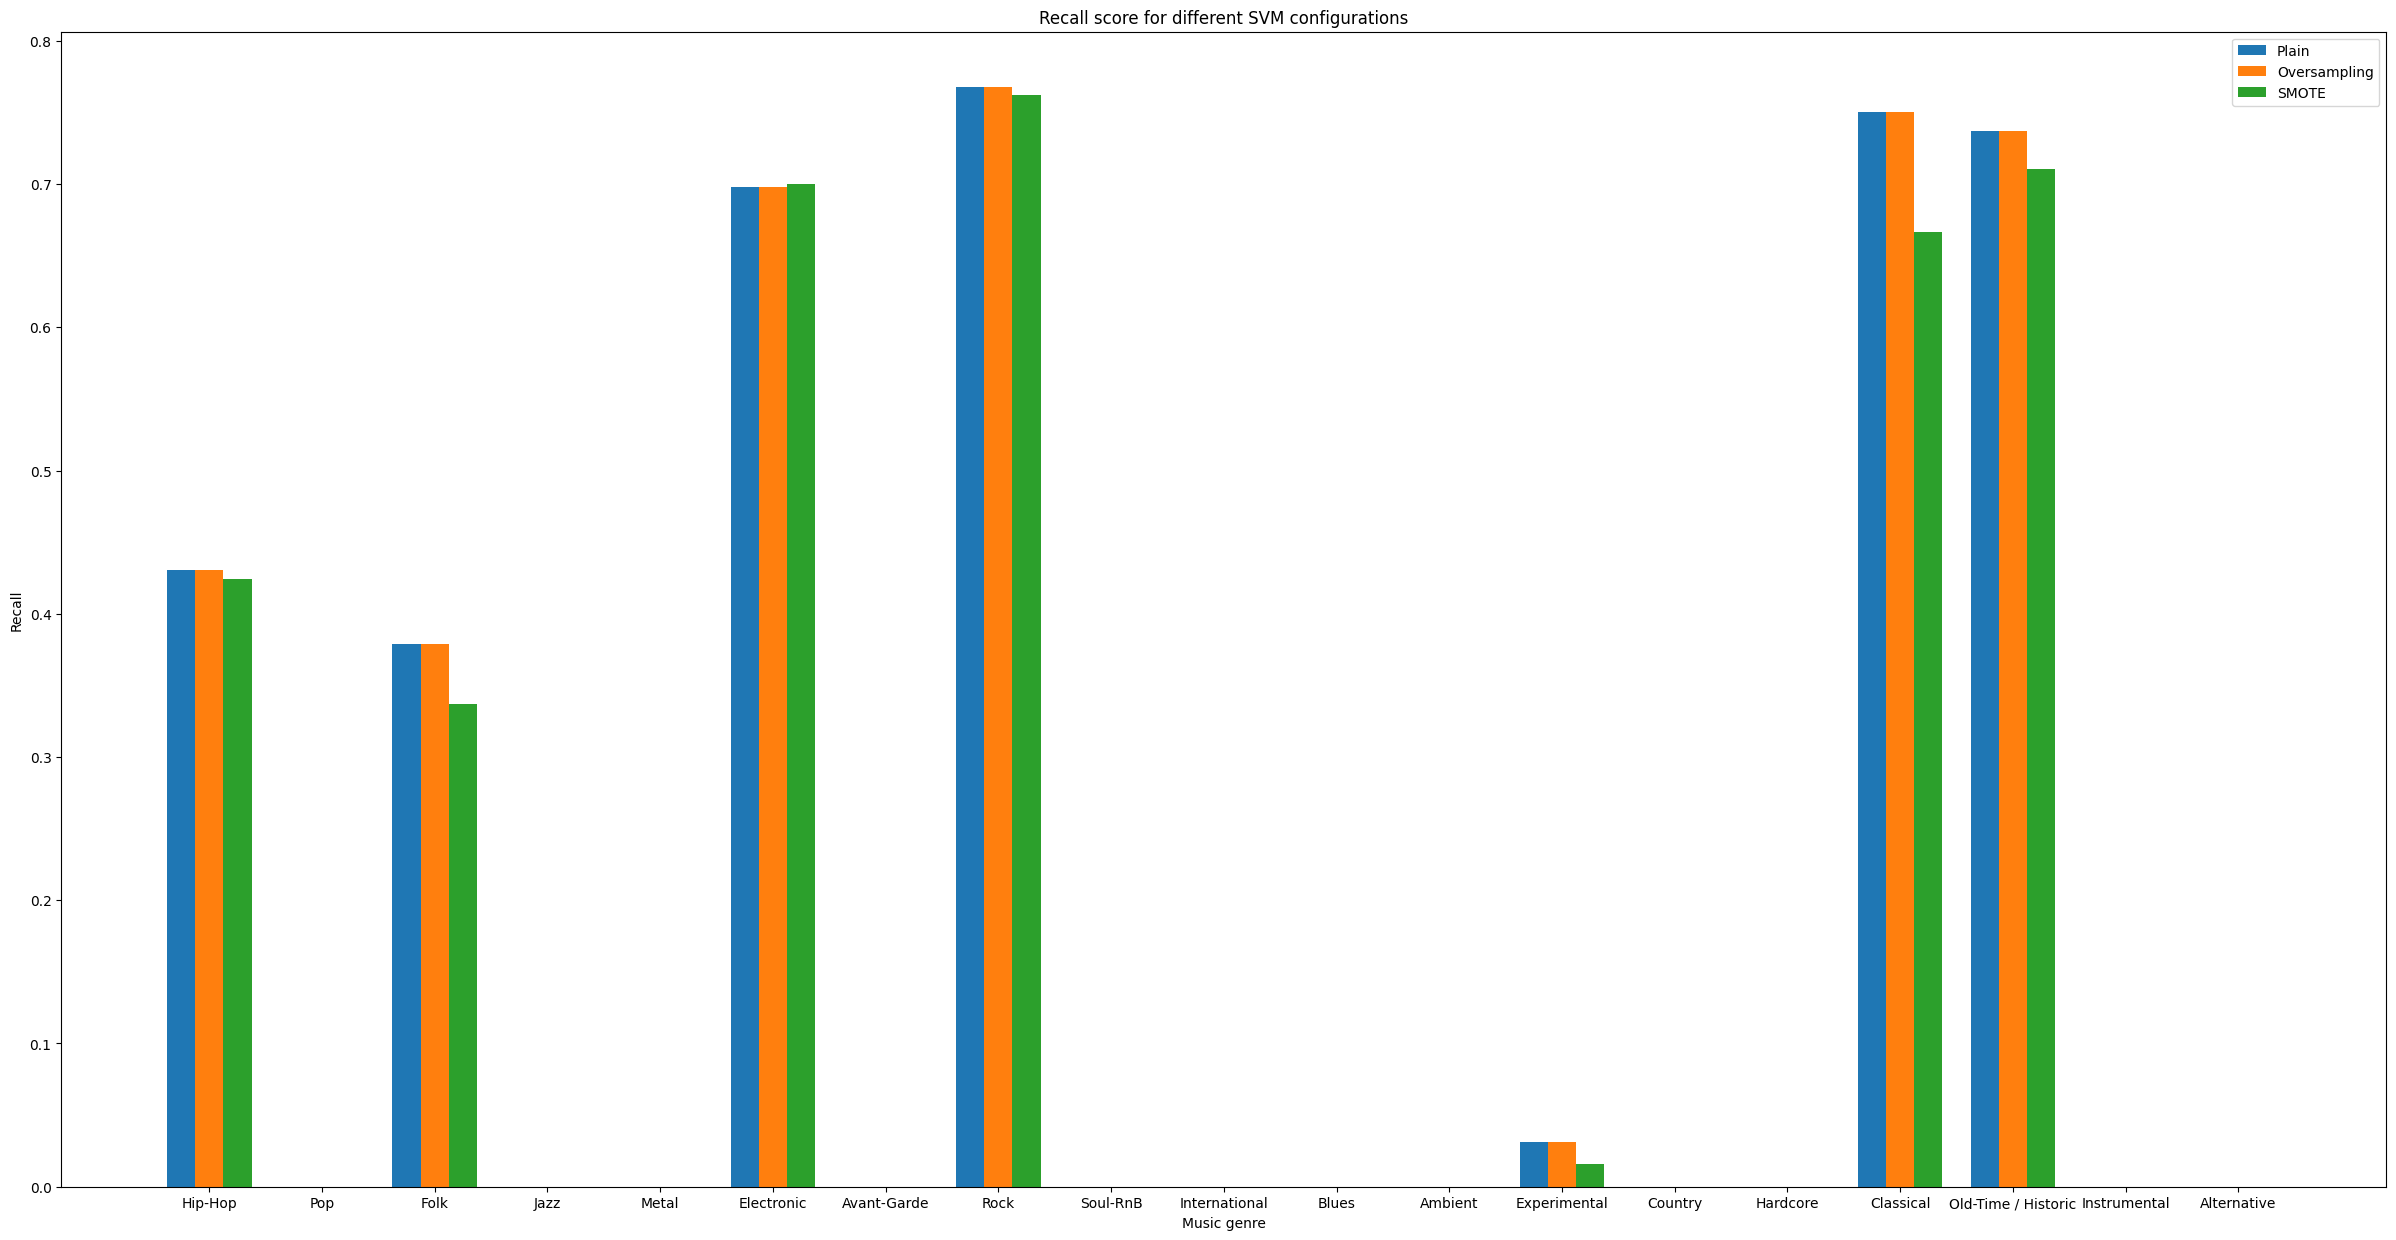

In [84]:
three_group_bar_plot(svm_recall, svm_recall_os, svm_recall_smote, 
                     le.inverse_transform(labels), 
                     "Recall score for different SVM configurations", "Music genre", 
                    "Recall")

Text(0, 0.5, 'F1-score')

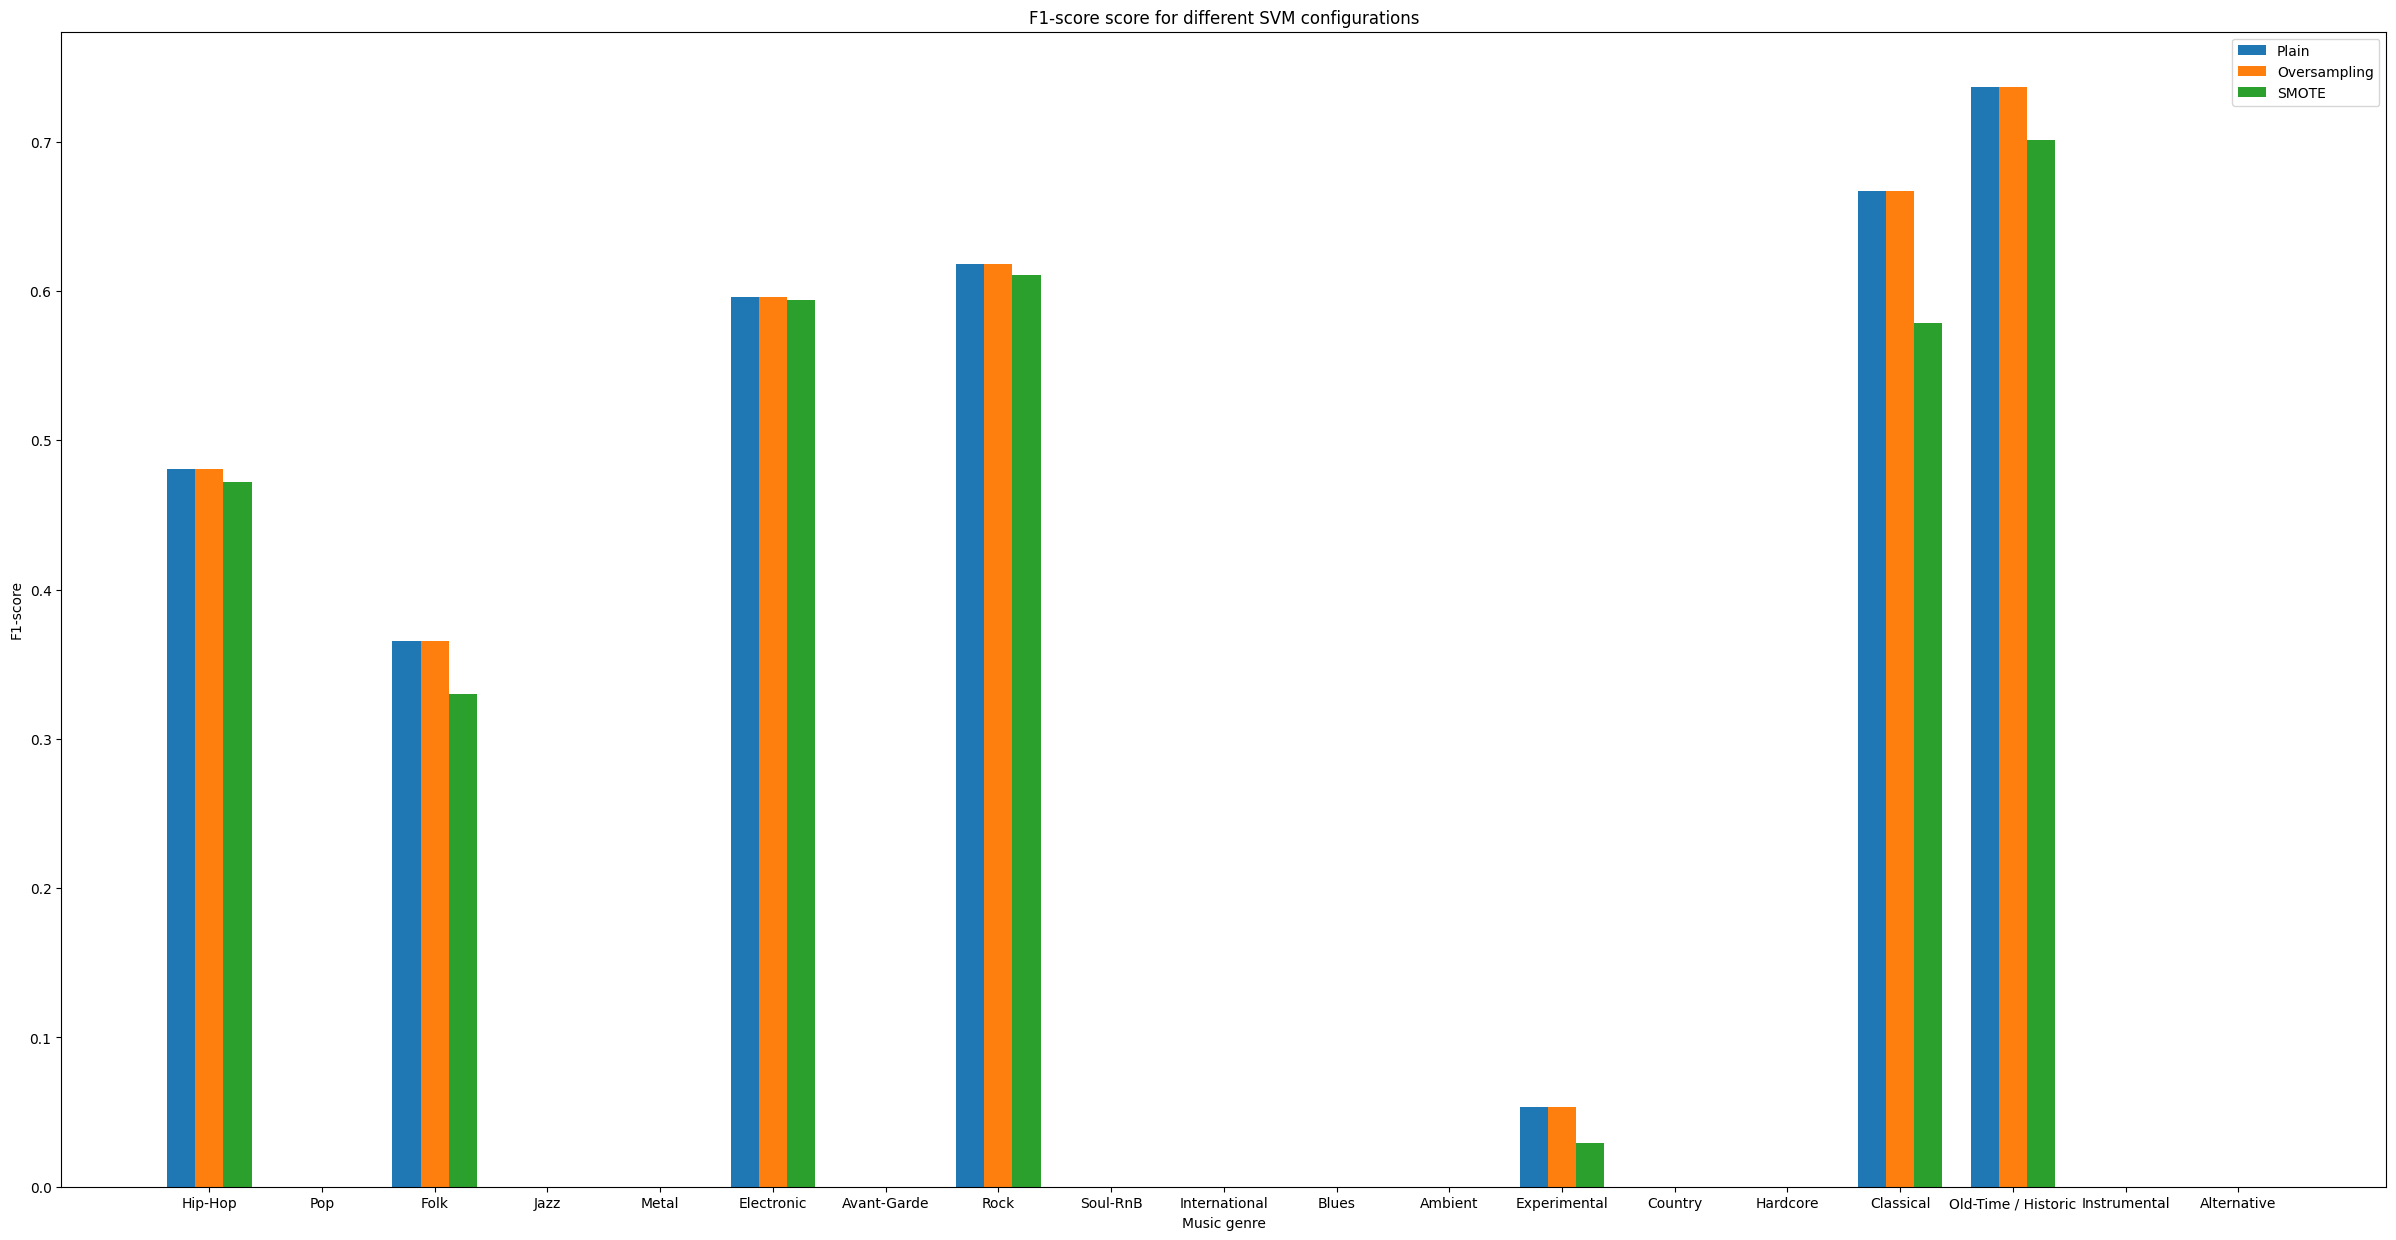

In [85]:
three_group_bar_plot(svm_f1, svm_f1_os, svm_f1_smote, 
                     le.inverse_transform(labels), 
                     "F1-score for different SVM configurations", "Music genre", 
                    "F1-score")

### SVM on test set

In [ ]:
orig_labels = le.inverse_transform(labels)

if EXEC_PROFILE["OVERS"]:
    svm_clf = skl.svm.SVC(C=C_best, kernel='rbf').fit(X_train_os, y_train_os)
    svm_test_preds = svm_clf.predict(X_test_os)
    
    svm_results = compute_class_metrics(
        predictions=le.inverse_transform(svm_test_preds), 
        y_set=le.inverse_transform(y_test_os), 
        labels= orig_labels
    )

    svm_report = svm_results[0]
    svm_precision = svm_results[1]
    svm_recall = svm_results[2]
    svm_f1 = svm_results[3]
    
elif EXEC_PROFILE["SMOTE"]
    svm_clf = skl.svm.SVC(C=C_best, kernel='rbf').fit(X_train_smote, y_train_smote)
    svm_test_preds = svm_clf.predict(X_test_smote)
    svm_results = compute_class_metrics(
        predictions=le.inverse_transform(svm_test_preds), 
        y_set=le.inverse_transform(y_test_smote), 
        labels=orig_labels
    )

    svm_report = svm_results[0]
    svm_precision = svm_results[1]
    svm_recall = svm_results[2]
    svm_f1 = svm_results[3]
    
else:
    svm_clf = skl.svm.SVC(C=C_best, kernel='rbf').fit(X_train, y_train)
    svm_test_preds = svm_clf.predict(X_test)
    svm_results = compute_class_metrics(
        predictions = le.inverse_transform(svm_test_preds), 
        y_set= le.inverse_transform(y_test), 
        labels=orig_labels
    )

    svm_report = svm_results[0]
    svm_precision = svm_results[1]
    svm_recall = svm_results[2]
    svm_f1 = svm_results[3]
    
#svm_val_predict_smote = cross_val_predict(svm_clf_smote, X_validate, y_validate, cv=5)

# vector structure: [report, precision, recall, f1-score]

# Finally, show the results
svm_report
bar_plot((25,10), svm_precision, orig_labels, 'Precision metric values for SVM')
bar_plot((25,10), svm_recall, orig_labels, 'Recall metric values for SVM')
bar_plot((25,10), svm_f1, orig_labels, 'F1 metric values for SVM')

# TODO: confusino matrix?

In [111]:
'''
# Output the confusion matrix on a .csv file
svm_cm = confusion_matrix(le.inverse_transform(y_validate), 
                          le.inverse_transform(svm_val_predict_os), 
                          labels=le.inverse_transform(labels))
string_labels = le.inverse_transform(labels)
write_cm_on_file(cm=svm_cm, labels=string_labels, path="confusion_matrix_svm.csv")
'''

## LR classification

### LR without tweaks

In [ ]:
lr_clf = LogisticRegression(C=1, penalty="None", dual=False, solver=solver).fit(X_train, y_train)
lr_val_predict = cross_val_predict(lr_clf, X_validate, y_validate, cv=5)

lr_results = compute_class_metrics(predictions=le.inverse_transform(lr_val_predict), 
                                y_set=le.inverse_transform(y_validate), 
                                labels=le.inverse_transform(labels))
lr_report = lr_results[0]
lr_precision = lr_results[1]
lr_recall = lr_results[2]
lr_f1 = lr_results[3]
#lr_cm = confusion_matrix(y_test, lr_predict, labels=labels)

print("------------------------------ LR completed ------------------------------")

### LR with oversampling

In [ ]:
lr_clf_os = LogisticRegression(C=1, penalty="None", dual=False, solver=solver).fit(X_train_os, 
                                                                                   y_train_os)
lr_val_predict_os = cross_val_predict(lr_clf_os, X_validate, y_validate, cv=5)

lr_results_os = compute_class_metrics(predictions=le.inverse_transform(lr_val_predict_os), 
                                y_set=le.inverse_transform(y_validate), 
                                labels=le.inverse_transform(labels))
lr_report_os = lr_results_os[0]
lr_precision_os = lr_results_os[1]
lr_recall_os = lr_results_os[2]
lr_f1_os = lr_results_os[3]

### LR with SMOTE

In [ ]:
lr_clf_smote = LogisticRegression(C=1, penalty="None", dual=False, solver=solver).fit(
    X_train_smote, y_train_smote)
lr_val_predict_smote = cross_val_predict(lr_clf_smote, X_validate, y_validate, cv=5)

lr_results_smote = compute_class_metrics(predictions=le.inverse_transform(lr_val_predict_smote), 
                                y_set=le.inverse_transform(y_validate), 
                                labels=le.inverse_transform(labels))
lr_report_smote = lr_results_smote[0]
lr_precision_smote = lr_results_smote[1]
lr_recall_smote = lr_results_smote[2]
lr_f1_smote = lr_results_smote[3]

### Metrics comparison for SVM

In [ ]:
# Print the summary tables
print("-------------------------------- Metrics without tweaks --------------------------------")
lr_report

In [ ]:
print("------------------------------ Metrics with oversampling ------------------------------")
lr_report_os

In [ ]:
print("-------------------------------- Metrics with SMOTE --------------------------------")
lr_report_smote

In [ ]:
three_group_bar_plot(lr_precision, lr_precision_os, lr_precision_smote, 
                     le.inverse_transform(labels), 
                     "Precision score for different LR configurations", "Music genre", 
                    "Precision")

In [ ]:
three_group_bar_plot(lr_recall, lr_recall_os, lr_recall_smote, 
                     le.inverse_transform(labels), 
                     "Recall score for different LR configurations", "Music genre", 
                    "Recall")

In [ ]:
three_group_bar_plot(lr_f1, lr_f1_os, lr_f1_smote, 
                     le.inverse_transform(labels), 
                     "F1-score for different LR configurations", "Music genre", 
                    "F1-score")

### LR on test set

In [ ]:
orig_labels = le.inverse_transform(labels)

if EXEC_PROFILE["OVERS"]:
    lr_clf = LogisticRegression(C=1, penalty=penalty_best, dual=False, 
                             solver=solver_best).fit(X_train_os, y_train_os)
    lr_test_preds = lr_clf.predict(X_test_os)
    
    lr_results = compute_class_metrics(
        predictions=le.inverse_transform(lr_test_preds), 
        y_set=le.inverse_transform(y_test_os), 
        labels= orig_labels
    )

    lr_report = svm_results[0]
    lr_precision = svm_results[1]
    lr_recall = svm_results[2]
    lr_f1 = svm_results[3]
    
elif EXEC_PROFILE["SMOTE"]
    lr_clf = LogisticRegression(C=1, penalty=penalty_best, dual=False, 
                                solver=solver_best).fit(X_train, y_train).fit(X_train_smote, 
                                                                           y_train_smote)
    lr_test_preds = lr_clf.predict(X_test_smote)
    lr_results = compute_class_metrics(
        predictions=le.inverse_transform(lr_test_preds), 
        y_set=le.inverse_transform(y_test_smote), 
        labels=orig_labels
    )

    lr_report = lr_results[0]
    lr_precision = lr_results[1]
    lr_recall = lr_results[2]
    lr_f1 = lr_results[3]
    
else:
    lr_clf = LogisticRegression(C=1, penalty=penalty_best, dual=False, 
                                solver=solver_best).fit(X_train, y_train)
    lr_test_preds = lr_clf.predict(X_test)
    lr_results = compute_class_metrics(
        predictions = le.inverse_transform(lr_test_preds), 
        y_set= le.inverse_transform(y_test), 
        labels=orig_labels
    )

    lr_report = lr_results[0]
    lr_precision = lr_results[1]
    lr_recall = lr_results[2]
    lr_f1 = lr_results[3]
    
#svm_val_predict_smote = cross_val_predict(svm_clf_smote, X_validate, y_validate, cv=5)

# vector structure: [report, precision, recall, f1-score]

# Finally, show the results
lr_report
bar_plot((25,10), lr_precision, orig_labels, 'Precision metric values for LR')
bar_plot((25,10), lr_recall, orig_labels, 'Recall metric values for LR')
bar_plot((25,10), lr_f1, orig_labels, 'F1 metric values for LR')

# TODO: confusino matrix?

## kNN classification

### kNN without tweaks

In [ ]:
knn_clf = KNeighborsClassifier(n_neighbours).fit(X_train, y_train)
knn_val_predict = cross_val_predict(knn_clf, X_validate, y_validate, cv=5)

knn_results = compute_class_metrics(predictions=le.inverse_transform(knn_val_predict), 
                                y_set=le.inverse_transform(y_validate), 
                                labels=le.inverse_transform(labels))
knn_report = knn_results[0]
knn_precision = knn_results[1]
knn_recall = knn_results[2]
knn_f1 = knn_results[3]
#lr_cm = confusion_matrix(y_test, lr_predict, labels=labels)

print("------------------------------ kNN completed ------------------------------")

### kNN with oversampling

In [ ]:
knn_clf = KNeighborsClassifier(n_neighbours).fit(X_train_os, y_train_os)
knn_val_predict_os = cross_val_predict(knn_clf, X_validate, y_validate, cv=5)

knn_results_os = compute_class_metrics(predictions=le.inverse_transform(knn_val_predict_os), 
                                y_set=le.inverse_transform(y_validate), 
                                labels=le.inverse_transform(labels))
knn_report_os = knn_results_os[0]
knn_precision_os = knn_results_os[1]
knn_recall_os = knn_results_os[2]
knn_f1_os = knn_results_os[3]
#lr_cm = confusion_matrix(y_test, lr_predict, labels=labels)

print("------------------------------ kNN oversampling completed ------------------------------")

### kNN with SMOTE

In [ ]:
knn_clf = KNeighborsClassifier(n_neighbours).fit(X_train_smote, y_train_smote)
knn_val_predict_smote = cross_val_predict(knn_clf, X_validate, y_validate, cv=5)

knn_results_smote = compute_class_metrics(
    predictions=le.inverse_transform(knn_val_predict_smote), 
    y_set=le.inverse_transform(y_validate), 
    labels=le.inverse_transform(labels))

knn_report_smote = knn_results_smote[0]
knn_precision_smote = knn_results_smote[1]
knn_recall_smote = knn_results_smote[2]
knn_f1_smote = knn_results_smote[3]
#lr_cm = confusion_matrix(y_test, lr_predict, labels=labels)

print("------------------------------ kNN SMOTE completed ------------------------------")

### Metrics comparison for kNN

In [ ]:
# Print the summary tables
print("-------------------------------- Metrics without tweaks --------------------------------")
lr_report

In [ ]:
print("------------------------------ Metrics with oversampling ------------------------------")
lr_report_os

In [ ]:
print("-------------------------------- Metrics with SMOTE --------------------------------")
lr_report_smote

In [ ]:
three_group_bar_plot(knn_precision, knn_precision_os, knn_precision_smote, 
                     le.inverse_transform(labels), 
                     "Precision score for different kNN configurations", "Music genre", 
                    "Precision")

In [ ]:
three_group_bar_plot(knn_recall, knn_recall_os, knn_recall_smote, 
                     le.inverse_transform(labels), 
                     "Recall score for different kNN configurations", "Music genre", 
                    "Recall")

In [ ]:
three_group_bar_plot(knn_f1, knn_f1_os, knn_f1_smote, 
                     le.inverse_transform(labels), 
                     "F1-score for different kNN configurations", "Music genre", 
                    "F1-score")

### kNN on test set

In [25]:
orig_labels = le.inverse_transform(labels)

if EXEC_PROFILE["OVERS"]:
    knn_clf = KNeighborsClassifier(n_neighbours).fit(X_train_os, y_train_os)
    knn_test_preds = knn_clf.predict(X_test_os)
    
    knn_results = compute_class_metrics(
        predictions=le.inverse_transform(knn_test_preds), 
        y_set=le.inverse_transform(y_test_os), 
        labels= orig_labels
    )

    knn_report = knn_results[0]
    knn_precision = knn_results[1]
    knn_recall = knn_results[2]
    knn_f1 = knn_results[3]
    
elif EXEC_PROFILE["SMOTE"]
    knn_clf = KNeighborsClassifier(n_neighbours).fit(X_train_smote, y_train_smote)
    knn_test_preds = knn_clf.predict(X_test_smote)
    knn_results = compute_class_metrics(
        predictions=le.inverse_transform(knn_test_preds), 
        y_set=le.inverse_transform(y_test_smote), 
        labels=orig_labels
    )

    knn_report = knn_results[0]
    knn_precision = knn_results[1]
    knn_recall = knn_results[2]
    knn_f1 = knn_results[3]
    
else:
    knn_clf = KNeighborsClassifier(n_neighbours).fit(X_train, y_train)
    knn_test_preds = knn_clf.predict(X_test)
    knn_results = compute_class_metrics(
        predictions = le.inverse_transform(knn_test_preds), 
        y_set= le.inverse_transform(y_test), 
        labels=orig_labels
    )

    knn_report = knn_results[0]
    knn_precision = knn_results[1]
    knn_recall = knn_results[2]
    knn_f1 = knn_results[3]

# Finally, show the results
knn_report
bar_plot((25,10), knn_precision, orig_labels, 'Precision metric values for kNN')
bar_plot((25,10), knn_recall, orig_labels, 'Recall metric values for kNN')
bar_plot((25,10), knn_f1, orig_labels, 'F1 metric values for kNN')

# TODO: confusino matrix?

0.47862480935434676
0.46474358974358976
------------------------- kNN completed -------------------------


/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## MLP classification

### MLP without tweaks

In [ ]:
mlp_clf = MLPClassifier(solver='adam', alpha=alpha, hidden_layer_sizes=(hidden_layer_sizes,), 
                            random_state=1).fit(X_train, y_train)
mlp_val_predict = cross_val_predict(mlp_clf, X_validate, y_validate, cv=5)

mlp_results = compute_class_metrics(predictions=le.inverse_transform(mlp_val_predict), 
                                y_set=le.inverse_transform(y_validate), 
                                labels=le.inverse_transform(labels))
mlp_report = mlp_results[0]
mlp_precision = mlp_results[1]
mlp_recall = mlp_results[2]
mlp_f1 = mlp_results[3]
#lr_cm = confusion_matrix(y_test, lr_predict, labels=labels)

print("------------------------------ MLP completed ------------------------------")

### MLP with oversampling

In [ ]:
mlp_clf = MLPClassifier(solver='adam', alpha=alpha, hidden_layer_sizes=(hidden_layer_sizes,), 
                            random_state=1).fit(X_train_os, y_train_os)
mlp_val_predict_os = cross_val_predict(mlp_clf, X_validate, y_validate, cv=5)

mlp_results_os = compute_class_metrics(predictions=le.inverse_transform(mlp_val_predict_os), 
                                y_set=le.inverse_transform(y_validate), 
                                labels=le.inverse_transform(labels))
mlp_report_os = mlp_results_os[0]
mlp_precision_os = mlp_results_os[1]
mlp_recall_os = mlp_results_os[2]
mlp_f1_os = mlp_results_os[3]
#lr_cm = confusion_matrix(y_test, lr_predict, labels=labels)

print("------------------------------ MLP oversampling completed ------------------------------")

### MLP with SMOTE

In [ ]:
mlp_clf = MLPClassifier(solver='adam', alpha=alpha, hidden_layer_sizes=(hidden_layer_sizes,), 
                            random_state=1).fit(X_train_smote, y_train_smote)
mlp_val_predict_smote = cross_val_predict(mlp_clf, X_validate, y_validate, cv=5)

mlp_results_smote = compute_class_metrics(
    predictions=le.inverse_transform(mlp_val_predict_smote), 
    y_set=le.inverse_transform(y_validate), 
    labels=le.inverse_transform(labels))

mlp_report_smote = mlp_results_smote[0]
mlp_precision_smote = mlp_results_smote[1]
mlp_recall_smote = mlp_results_smote[2]
mlp_f1_smote = mlp_results_smote[3]
#lr_cm = confusion_matrix(y_test, lr_predict, labels=labels)

print("------------------------------ MLP SMOTE completed ------------------------------")

### Metrics comparison for MLP

In [ ]:
print("-------------------------------- Metrics without tweaks --------------------------------")
mlp_report

In [ ]:
print("------------------------------ Metrics with oversampling ------------------------------")
mlp_report_os

In [ ]:
print("-------------------------------- Metrics with SMOTE --------------------------------")
mlp_report_smote

In [ ]:
three_group_bar_plot(mlp_precision, mlp_precision_os, mlp_precision_smote, 
                     le.inverse_transform(labels), 
                     "Precision score for different MLP configurations", "Music genre", 
                    "Precision")

In [ ]:
three_group_bar_plot(mlp_recall, mlp_recall_os, mlp_recall_smote, 
                     le.inverse_transform(labels), 
                     "Recall score for different MLP configurations", "Music genre", 
                    "Recall")

In [ ]:
three_group_bar_plot(mlp_f1, mlp_f1_os, mlp_f1_smote, 
                     le.inverse_transform(labels), 
                     "F1-score for different MLP configurations", "Music genre", 
                    "F1-score")

### MLP on test set

In [21]:
orig_labels = le.inverse_transform(labels)

if EXEC_PROFILE["OVERS"]:
    mlp_clf = MLPClassifier(solver='adam', alpha=alpha, hidden_layer_sizes=(hidden_layer_sizes,), 
                            random_state=1).fit(X_train_os, y_train_os)
    mlp_test_preds = mlp_clf.predict(X_test_os)
    
    mlp_results = compute_class_metrics(
        predictions=le.inverse_transform(mlp_test_preds), 
        y_set=le.inverse_transform(y_test_os), 
        labels= orig_labels
    )

    mlp_report = mlp_results[0]
    mlp_precision = mlp_results[1]
    mlp_recall = mlp_results[2]
    mlp_f1 = mlp_results[3]
    
elif EXEC_PROFILE["SMOTE"]
    mlp_clf = MLPClassifier(solver='adam', alpha=alpha, hidden_layer_sizes=(hidden_layer_sizes,), 
                            random_state=1).fit(X_train_smote, y_train_smote)
    mlp_test_preds = mlp_clf.predict(X_test_smote)
    mlp_results = compute_class_metrics(
        predictions=le.inverse_transform(mlp_test_preds), 
        y_set=le.inverse_transform(y_test_smote), 
        labels=orig_labels
    )

    mlp_report = mlp_results[0]
    mlp_precision = mlp_results[1]
    mlp_recall = mlp_results[2]
    mlp_f1 = mlp_results[3]
    
else:
    mlp_clf = MLPClassifier(solver='adam', alpha=alpha, hidden_layer_sizes=(hidden_layer_sizes,), 
                            random_state=1).fit(X_train, y_train)
    mlp_test_preds = mlp_clf.predict(X_test)
    mlp_results = compute_class_metrics(
        predictions = le.inverse_transform(mlp_test_preds), 
        y_set= le.inverse_transform(y_test), 
        labels=orig_labels
    )

    mlp_report = mlp_results[0]
    mlp_precision = mlp_results[1]
    mlp_recall = mlp_results[2]
    mlp_f1 = mlp_results[3]

# Finally, show the results
mlp_report
bar_plot((25,10), mlp_precision, orig_labels, 'Precision metric values for MLP')
bar_plot((25,10), mlp_recall, orig_labels, 'Recall metric values for MLP')
bar_plot((25,10), mlp_f1, orig_labels, 'F1 metric values for MLP')

0.32834757834757833
0.4185897435897436


/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Decision Three classification

### DT without tweaks

In [ ]:
dt_clf = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf_best).fit(X_train, y_train)
dt_val_predict = cross_val_predict(dt_clf, X_validate, y_validate, cv=5)

dt_results = compute_class_metrics(predictions=le.inverse_transform(dt_val_predict), 
                                y_set=le.inverse_transform(y_validate), 
                                labels=le.inverse_transform(labels))

dt_report = dt_results[0]
dt_precision = dt_results[1]
dt_recall = dt_results[2]
dt_f1 = dt_results[3]
#lr_cm = confusion_matrix(y_test, lr_predict, labels=labels)

print("------------------------------ DT completed ------------------------------")

### DT with oversampling

In [ ]:
dt_clf = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf_best).fit(X_train_os, 
                                                                            y_train_os)
dt_val_predict_os = cross_val_predict(dt_clf, X_validate, y_validate, cv=5)

dt_results_os = compute_class_metrics(predictions=le.inverse_transform(dt_val_predict_os), 
                                y_set=le.inverse_transform(y_validate), 
                                labels=le.inverse_transform(labels))

dt_report_os = dt_results_os[0]
dt_precision_os = dt_results_os[1]
dt_recall_os = dt_results_os[2]
dt_f1_os = dt_results_os[3]
#lr_cm = confusion_matrix(y_test, lr_predict, labels=labels)

print("------------------------------ DT oversampling completed ------------------------------")

### DT with SMOTE

In [ ]:
dt_clf = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf_best).fit(X_train_smote, 
                                                                            y_train_smote)
dt_val_predict_smote = cross_val_predict(dt_clf, X_validate, y_validate, cv=5)

dt_results_smote = compute_class_metrics(predictions=le.inverse_transform(dt_val_predict_smote), 
                                y_set=le.inverse_transform(y_validate), 
                                labels=le.inverse_transform(labels))

dt_report_smote = dt_results_smote[0]
dt_precision_smote = dt_results_smote[1]
dt_recall_smote = dt_results_smote[2]
dt_f1_smote = dt_results_smote[3]
#lr_cm = confusion_matrix(y_test, lr_predict, labels=labels)

print("------------------------------ DT oversampling completed ------------------------------")

### Metrics comparison for DT

In [ ]:
print("-------------------------------- Metrics without tweaks --------------------------------")
dt_report

In [ ]:
print("------------------------------ Metrics with oversampling ------------------------------")
dt_report_os

In [ ]:
print("-------------------------------- Metrics with SMOTE --------------------------------")
dt_report_smote

In [ ]:
three_group_bar_plot(dt_precision, dt_precision_os, dt_precision_smote, 
                     le.inverse_transform(labels), 
                     "Precision score for different DT configurations", "Music genre", 
                    "Precision")

In [ ]:
three_group_bar_plot(dt_recall, dt_recall_os, dt_recall_smote, 
                     le.inverse_transform(labels), 
                     "Recall score for different DT configurations", "Music genre", 
                    "Recall")

In [ ]:
three_group_bar_plot(dt_f1, dt_f1_os, dt_f1_smote, 
                     le.inverse_transform(labels), 
                     "F1-score for different DT configurations", "Music genre", 
                    "F1-score")

### DT on test set

In [76]:
orig_labels = le.inverse_transform(labels)

if EXEC_PROFILE["OVERS"]:
    dt_clf = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf_best).fit(X_train_os, 
                                                                                y_train_os)
    dt_test_preds = dt_clf.predict(X_test_os)
    
    dt_results = compute_class_metrics(
        predictions=le.inverse_transform(dt_test_preds), 
        y_set=le.inverse_transform(y_test_os), 
        labels= orig_labels
    )

    dt_report = dt_results[0]
    dt_precision = dt_results[1]
    dt_recall = dt_results[2]
    dt_f1 = dt_results[3]
    
elif EXEC_PROFILE["SMOTE"]
    dt_clf = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf_best).fit(X_train_smote, 
                                                                                y_train_smote)
    dt_test_preds = dt_clf.predict(X_test_smote)
    dt_results = compute_class_metrics(
        predictions=le.inverse_transform(dt_test_preds), 
        y_set=le.inverse_transform(y_test_smote), 
        labels=orig_labels
    )

    dt_report = dt_results[0]
    dt_precision = dt_results[1]
    dt_recall = dt_results[2]
    dt_f1 = dt_results[3]
    
else:
    dt_clf = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf_best).fit(X_train, 
                                                                                y_train)
    dt_test_preds = mlp_clf.predict(X_test)
    dt_results = compute_class_metrics(
        predictions = le.inverse_transform(dt_test_preds), 
        y_set= le.inverse_transform(y_test), 
        labels=orig_labels
    )

    dt_report = dt_results[0]
    dt_precision = dt_results[1]
    dt_recall = dt_results[2]
    dt_f1 = dt_results[3]

# Finally, show the results
dt_report
bar_plot((25,10), dt_precision, orig_labels, 'Precision metric values for DT')
bar_plot((25,10), dt_recall, orig_labels, 'Recall metric values for DT')
bar_plot((25,10), dt_f1, orig_labels, 'F1 metric values for DT')

/usr/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.4537777777777778
0.53


# Challenge
To conclude the study, there is a little "challenge" among all classifiers considered.
<br>

In particular, a song is opened, loaded, the feature extracted and it is passed to the classifier to see which is the genre predicted.

In [13]:
# Instantiate all the classifiers and fit them
C_best = 20
n_hidden_opt = 70

svm_clf_chall = skl.svm.SVC(C=C_best, kernel='rbf', probability=True).fit(X_train, y_train)
lr_clf_chall = LogisticRegression(C=1, penalty="l1", dual=False, solver='saga').fit(X_train, y_train)
knn_clf_chall = KNeighborsClassifier(10).fit(X_train, y_train)
mlp_clf_chall = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(n_hidden_opt,), 
                            random_state=1).fit(X_train, y_train)
dt_clf_chall = DecisionTreeClassifier(min_samples_leaf=70).fit(X_train, y_train).fit(X_train, 
                                                                                     y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


C:\ProgramData\Anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


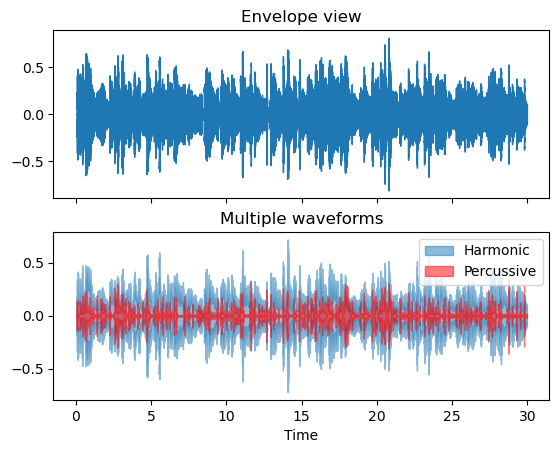

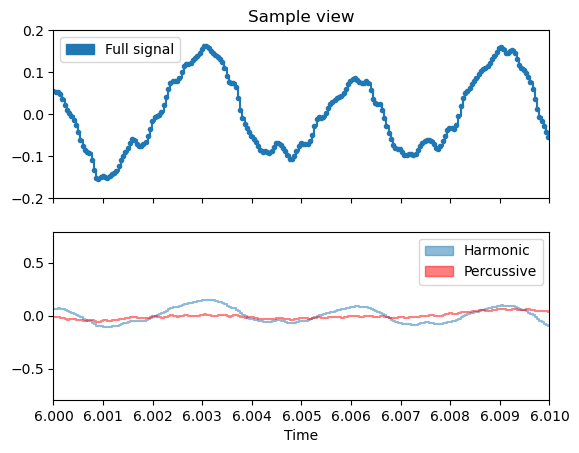

In [37]:
from utils import open_file_dialog
from Dataset_Generator import get_chroma_stft, get_chroma_cens, get_chroma_cqt, get_melspectrogram, get_mfcc, get_poly_features, get_rms, get_spectral_bandwidth, get_spectral_centroid, get_spectral_contrast, get_spectral_flatness, get_spectral_rolloff, get_tempogram, get_tonnetz, get_zero_crossing_rate

# Open dialogue box
file_path = open_file_dialog()
   
metrics = []

y, sr = librosa.load(file_path, offset=0, duration=30)
metrics.extend(calculate_metrics(get_chroma_stft(y, sr)))
metrics.extend(calculate_metrics(get_chroma_cens(y, sr)))
chroma_cqt = get_chroma_cqt(y, sr)
metrics.extend(calculate_metrics(chroma_cqt))
mel = get_melspectrogram(y, sr)
metrics.extend(calculate_metrics(mel))
metrics.extend(calculate_metrics(get_mfcc(y, sr)))
metrics.extend(calculate_metrics(get_poly_features(y, sr)))
metrics.extend(calculate_metrics(get_rms(y)))
metrics.extend(calculate_metrics(get_spectral_bandwidth(y, sr)))
metrics.extend(calculate_metrics(get_spectral_centroid(y, sr)))
metrics.extend(calculate_metrics(get_spectral_contrast(y, sr)))
metrics.extend(calculate_metrics(get_spectral_flatness(y)))
metrics.extend(calculate_metrics(get_spectral_rolloff(y, sr)))
metrics.extend(calculate_metrics(get_tempogram(y, sr)))
tonnetz = get_tonnetz(y, sr)
metrics.extend(calculate_metrics(tonnetz))
metrics.extend(calculate_metrics(get_zero_crossing_rate(y)))

X_test_elem = [metrics]

fig, ax = plt.subplots(nrows=2, sharex=True)
librosa.display.waveshow(y, sr=sr, ax=ax[0])
ax[0].set(title='Envelope view')
ax[0].label_outer()
y_harm, y_perc = librosa.effects.hpss(y)
librosa.display.waveshow(y_harm, sr=sr, alpha=0.5, ax=ax[1], label='Harmonic')
librosa.display.waveshow(y_perc, sr=sr, color='r', alpha=0.5, ax=ax[1], label='Percussive')
ax[1].set(title='Multiple waveforms')
ax[1].legend()

fig, (ax, ax2) = plt.subplots(nrows=2, sharex=True)
ax.set(xlim=[6.0, 6.01], title='Sample view', ylim=[-0.2, 0.2])
librosa.display.waveshow(y, sr=sr, ax=ax, marker='.', label='Full signal')
librosa.display.waveshow(y_harm, sr=sr, alpha=0.5, ax=ax2, label='Harmonic')
librosa.display.waveshow(y_perc, sr=sr, color='r', alpha=0.5, ax=ax2, label='Percussive')
ax.label_outer()
ax.legend()
ax2.legend()

Text(0.5, 1.0, 'Stft demonstration')

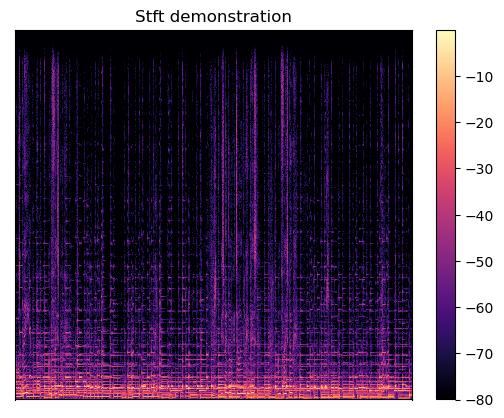

In [38]:
D = librosa.stft(y)  # STFT of y
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
plt.figure()
librosa.display.specshow(S_db)
plt.colorbar()
plt.title('Stft demonstration')

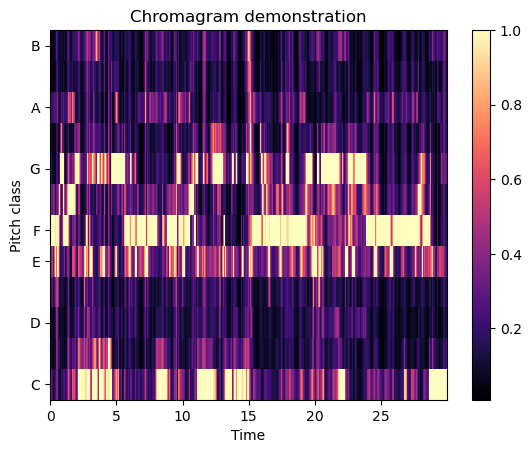

In [39]:
fig, ax = plt.subplots()
img = librosa.display.specshow(chroma_cqt, y_axis='chroma', x_axis='time', ax=ax)
ax.set(title='Chromagram demonstration')
fig.colorbar(img, ax=ax)

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

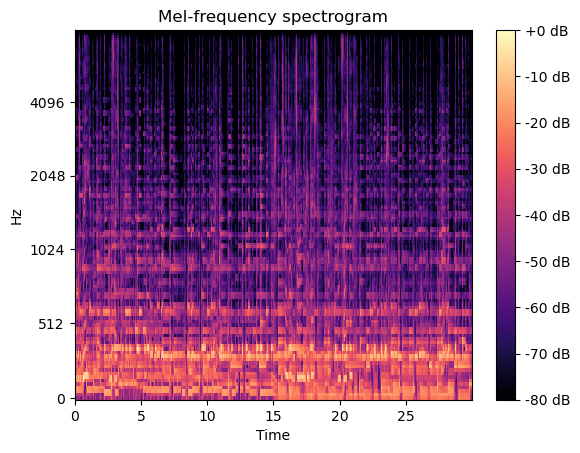

In [40]:
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(mel, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

[Text(0.5, 1.0, 'Tonal Centroids (Tonnetz)')]

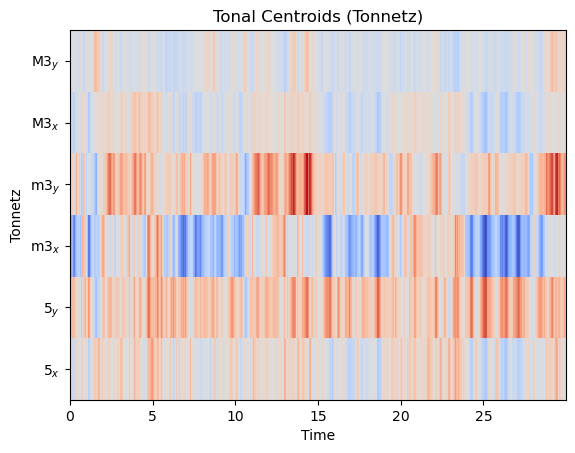

In [41]:
fig, ax = plt.subplots()
img = librosa.display.specshow(tonnetz,
                                y_axis='tonnetz', x_axis='time', ax=ax)
ax.set(title='Tonal Centroids (Tonnetz)')

In [21]:
import warnings
warnings.filterwarnings("ignore")

# Convert predicitions to a dictionary of the form `label_name`:value
#
# @param string_labels: list of labels
# @param probs:         list of predicted probabilites
#
# @returns: dictonary
def preds_to_dict(string_labels, probs):
    probs_dict = {}
    for index in range(0, len(string_labels)):
        probs_dict[string_labels[index]] = probs[index]
    return probs_dict

# Get the probability scores for each classifier.
# We are supposing that the X train and y train are just the one element that we are trying
# to classify.
orig_labels = le.inverse_transform(labels) # convert labels back
orig_labels.sort()

svm_probs = svm_clf_chall.predict_proba(X_test_elem)
lr_probs = lr_clf_chall.predict_proba(X_test_elem)
knn_probs = knn_clf_chall.predict_proba(X_test_elem)
mlp_probs = mlp_clf_chall.predict_proba(X_test_elem)
dt_probs = dt_clf_chall.predict_proba(X_test_elem)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


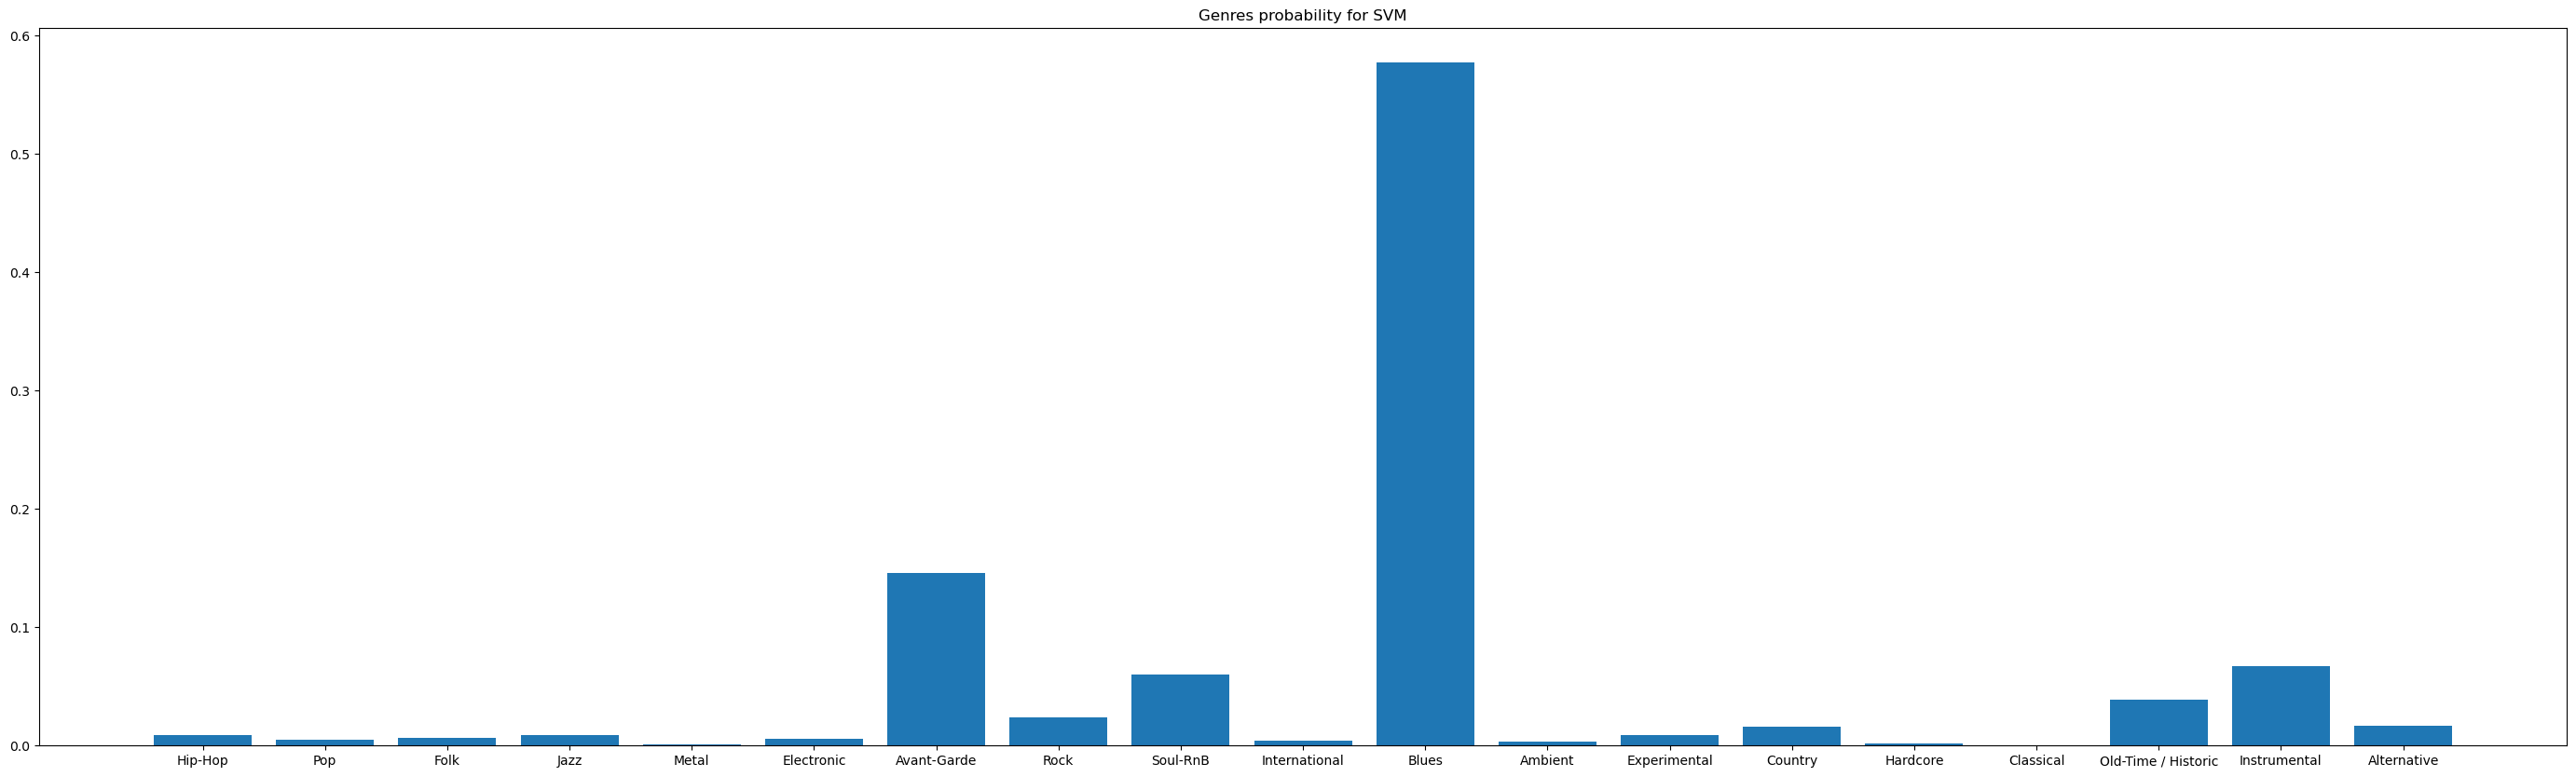

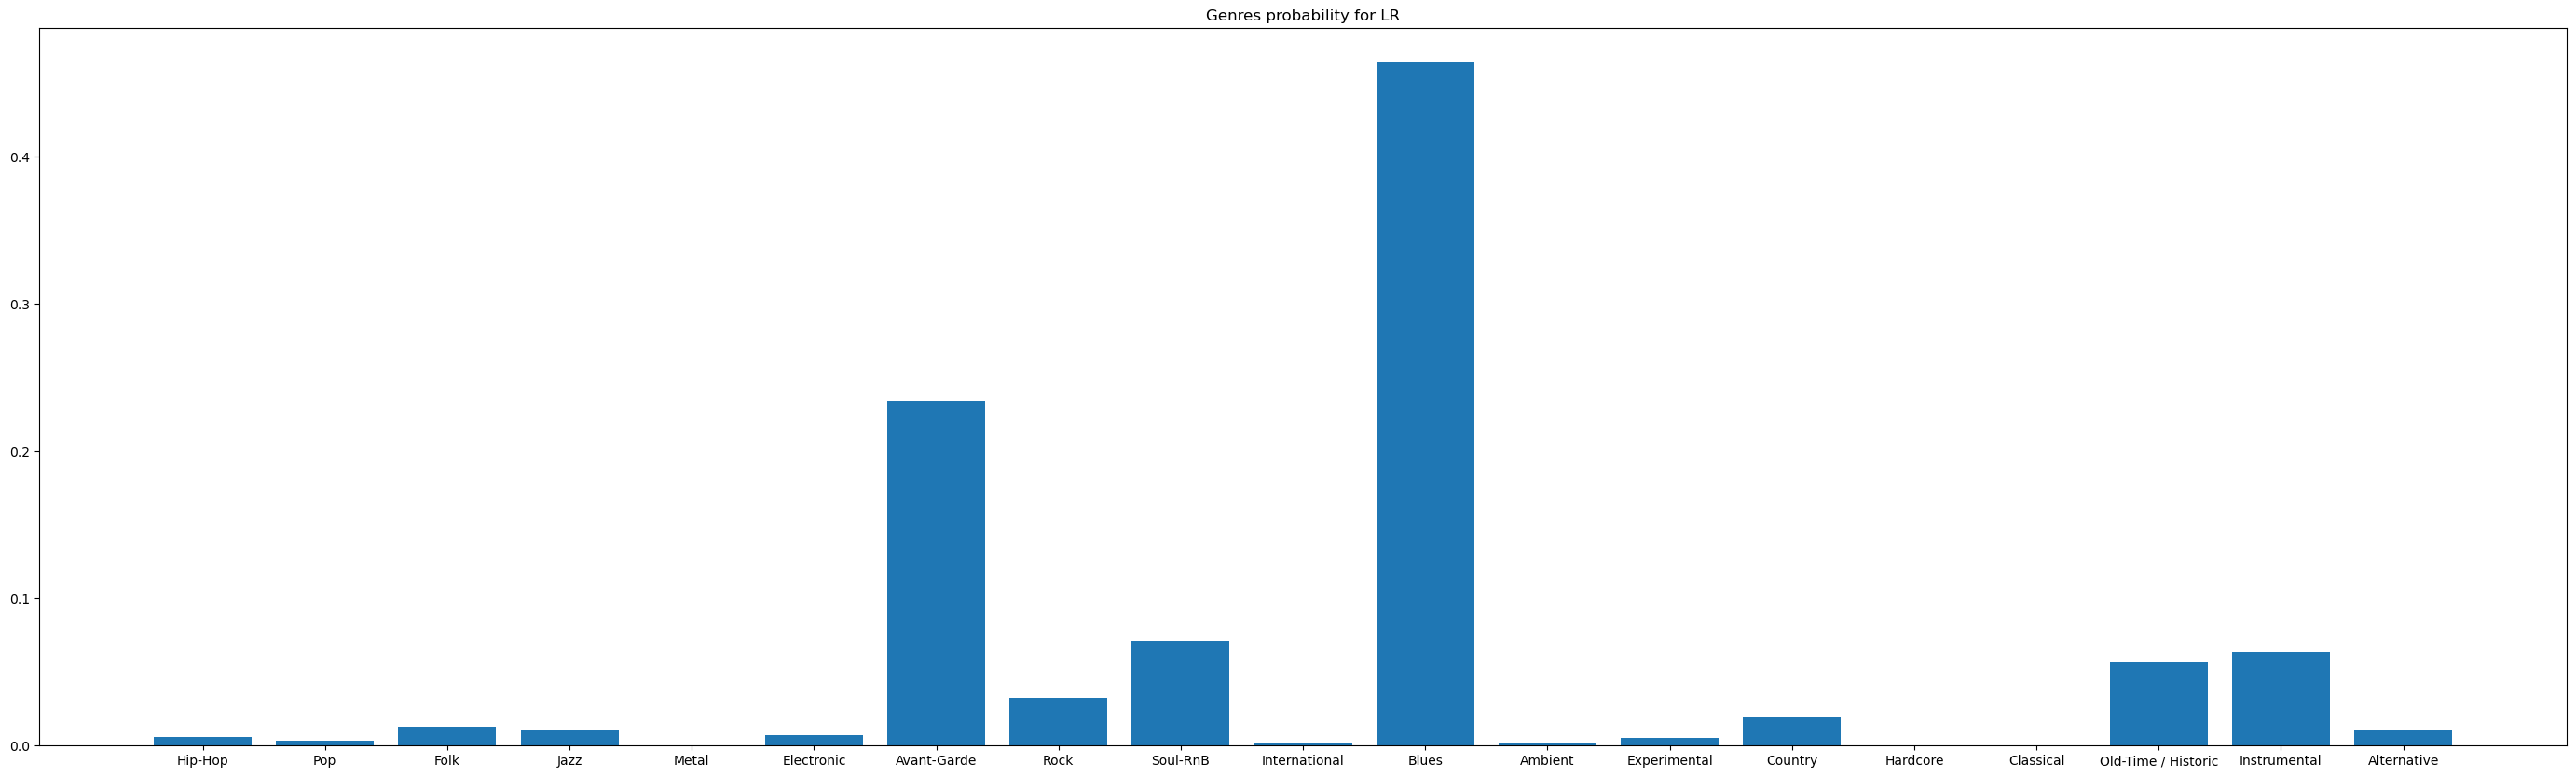

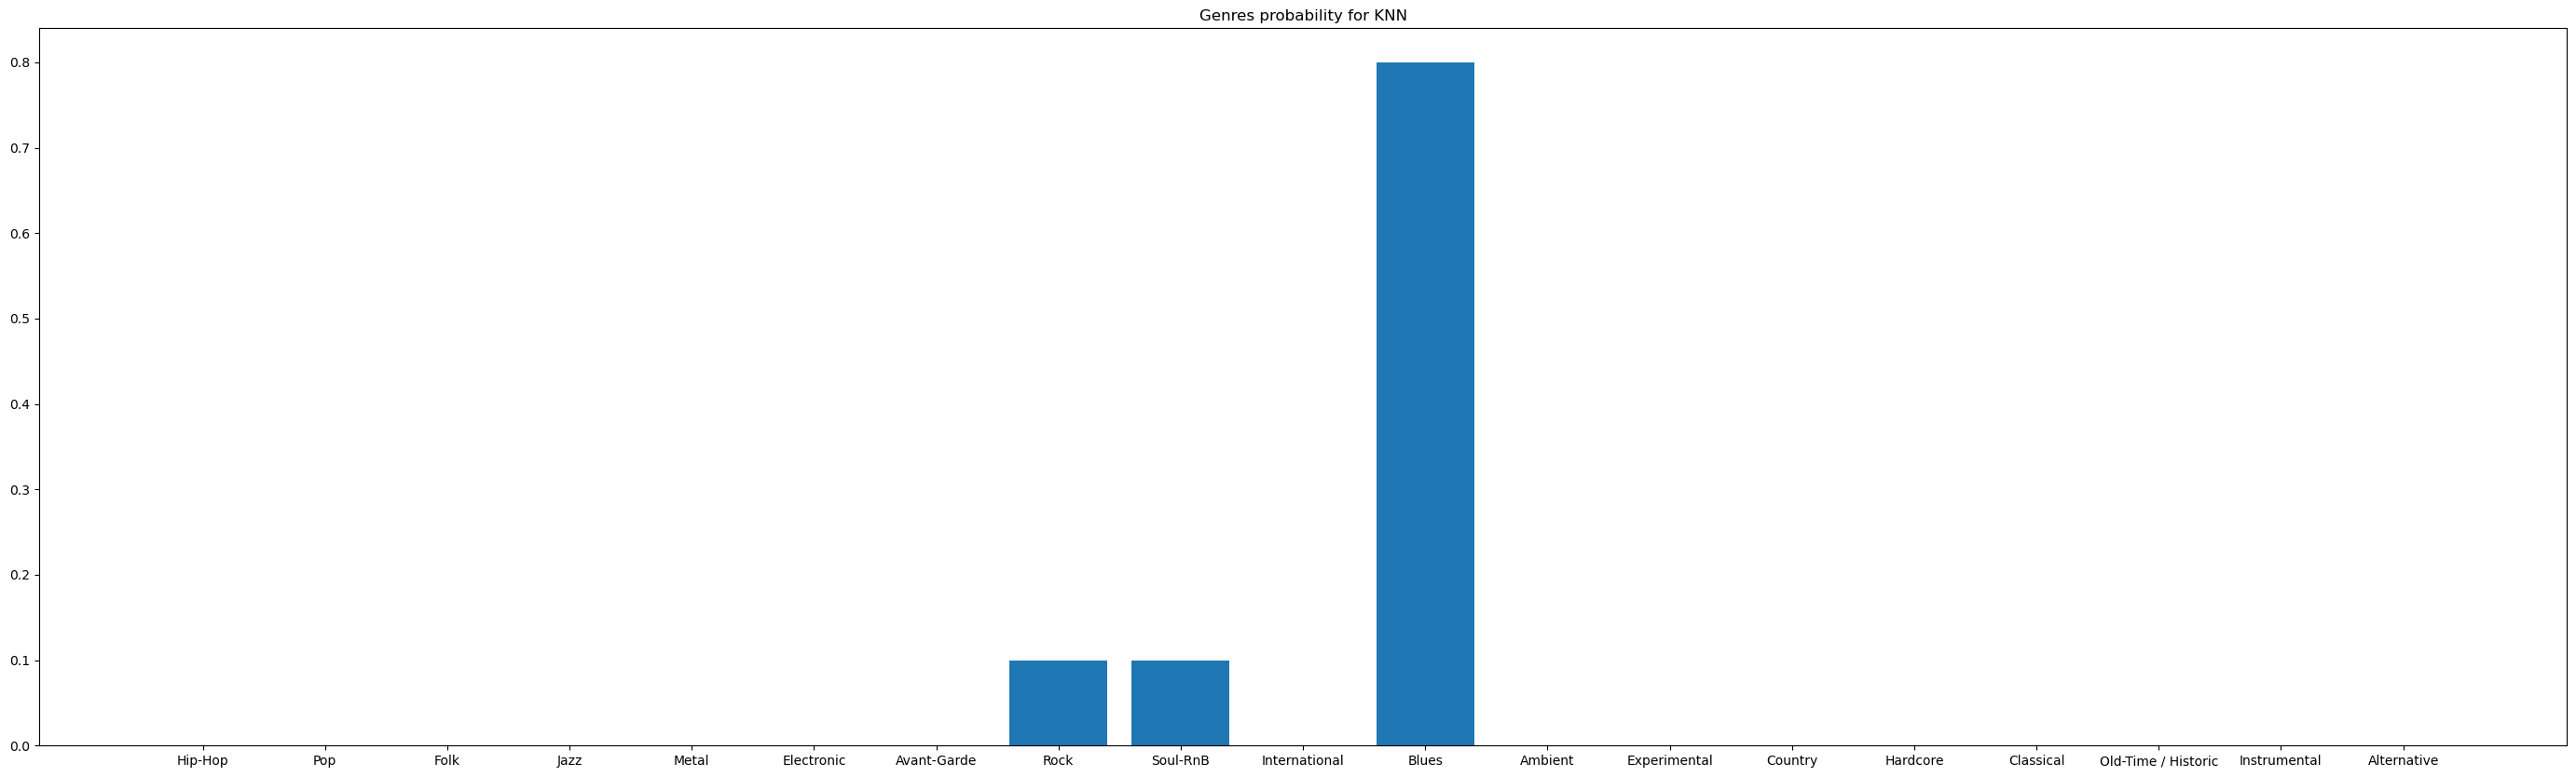

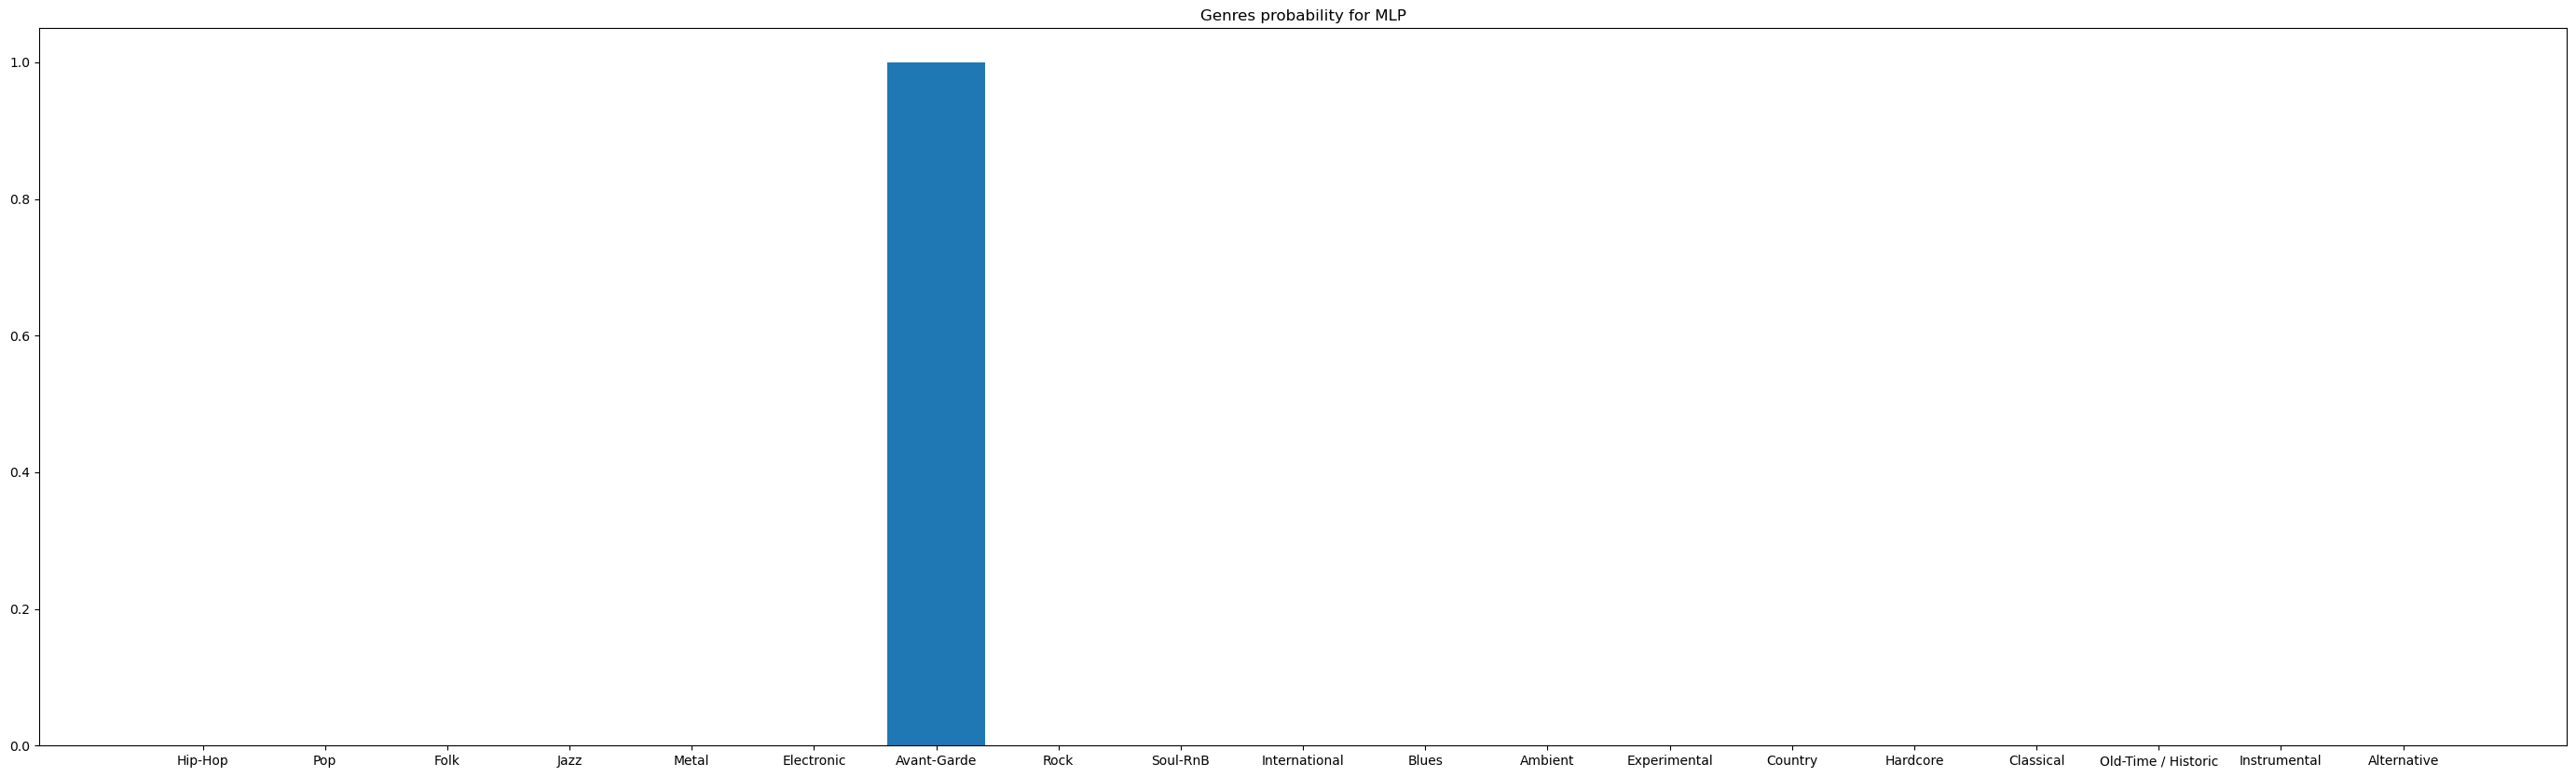

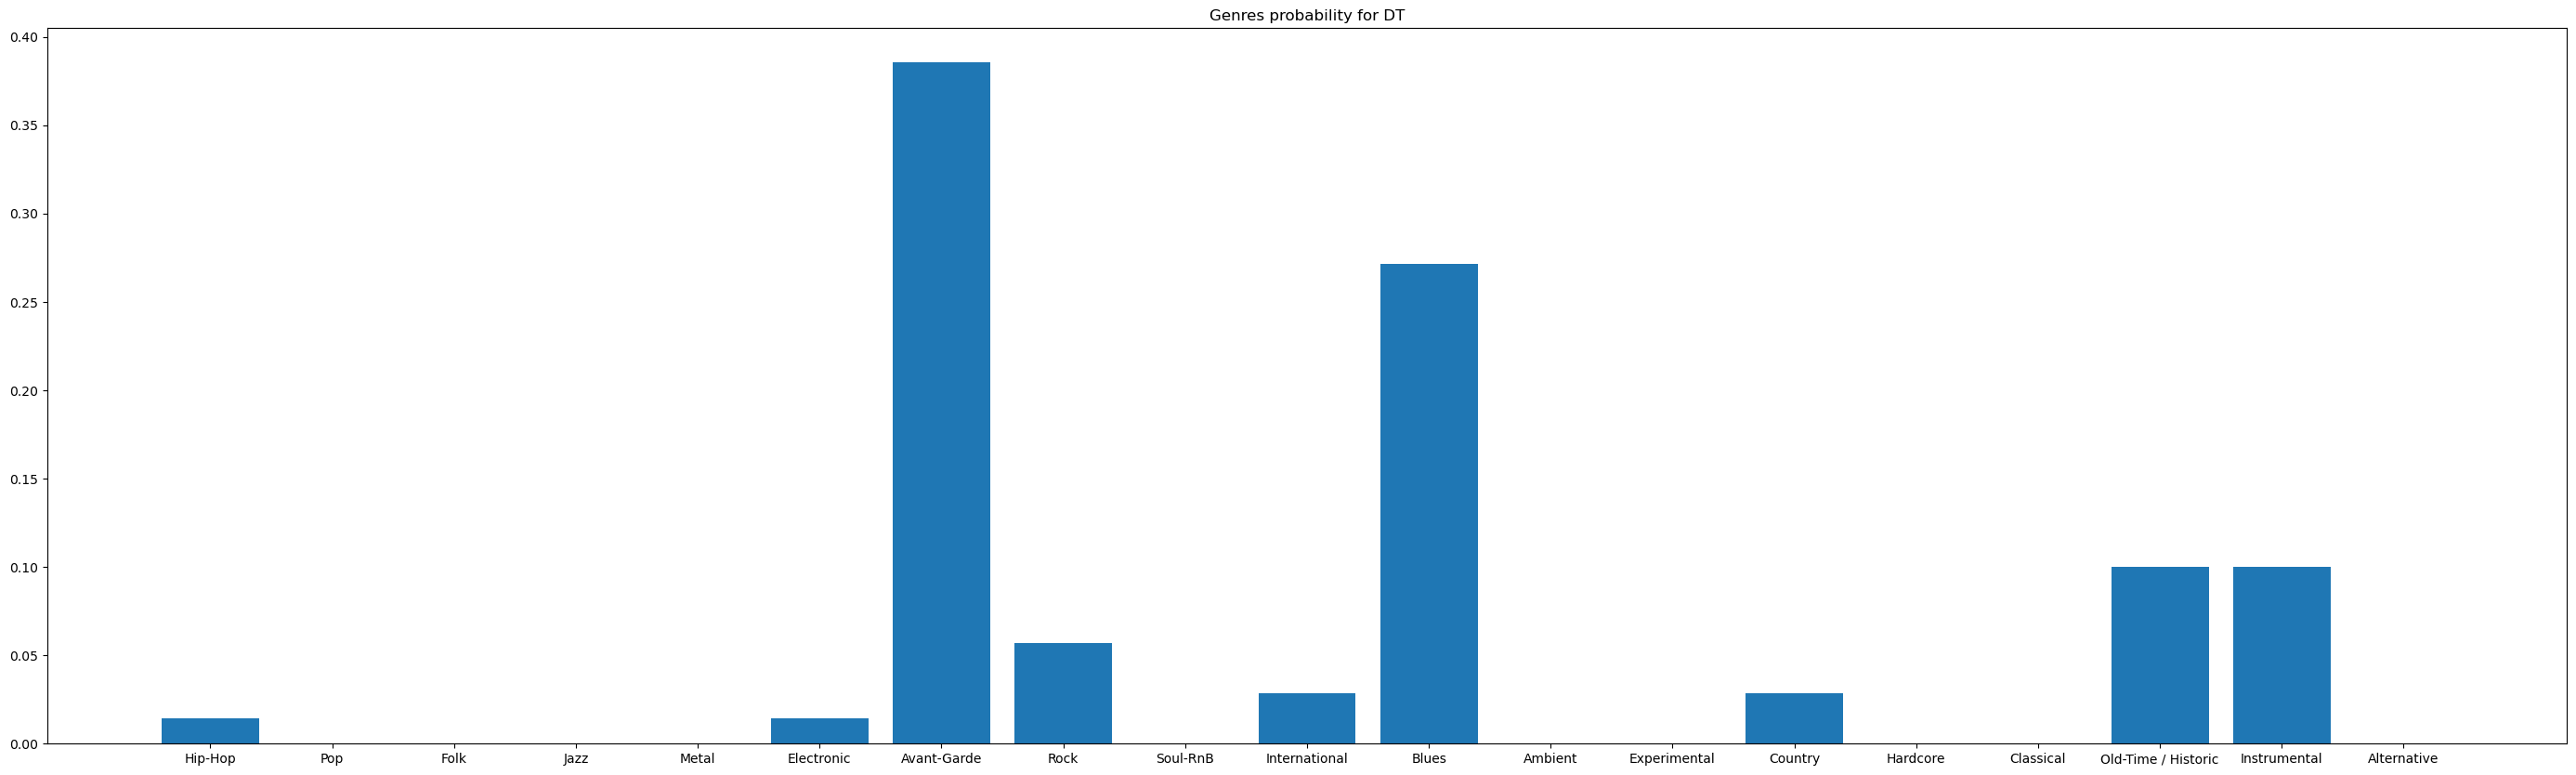

In [22]:
bar_plot((35,10), svm_probs[0], orig_labels, 'Genres probability for SVM')
bar_plot((35,10), lr_probs[0], orig_labels, 'Genres probability for LR')
bar_plot((35,10), knn_probs[0], orig_labels, 'Genres probability for KNN')
bar_plot((35,10), mlp_probs[0], orig_labels, 'Genres probability for MLP')
bar_plot((35,10), dt_probs[0], orig_labels, 'Genres probability for DT')

## Conclusions
Conclusioni tipo:
- "miglior" classificatore
- limiti e difficoltà incontrare
- etc...

## Bibliography
1. [FMA paper](https://arxiv.org/abs/1612.01840)